## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 1000
top = .97
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
gpu = '0'
cuda = "cuda:0"
device = torch.device(cuda)
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths; TRAINING, VALIDATION, AND SMALL TEST SETS

In [3]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
# path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
# path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
# path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
# path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
# path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
# path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
# path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
# path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
# path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
# path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
# path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
# path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
path_output2D = "/home/david/sigMF_ML/RF/RF_class/output_2D/"
path_output4D = "/home/david/sigMF_ML/RF/RF_class/output_4D/"
path_confuse = "/home/david/sigMF_ML/RF/RF_class/confuse/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


In [4]:
# print(path_test)

# os.chdir(path_test)
# data_files_test = sorted(glob.glob('*.sigmf-data'))
# meta_files_test = sorted(glob.glob('*.sigmf-meta'))

## Functions 

In [5]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model():
    rf_model = 'ResNet50_20210810_mix_autosave_GPU0'
    PATH = path_save+rf_model
    torch.save(model.state_dict(), PATH)
    
# model = resnet50(4, 12) # number of input channels, number of classes
# model.load_state_dict
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
# CUDA     

def load_model(rf_model):
    PATH = path_save+rf_model
    device = torch.device(cuda)
    model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model

def gpu_test_file(db,msps):
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps        
    elif (msps == 25):
        w1 = fft*msps 
#     print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     print('Sample Rate = ',w,'MSPS')
    den = 2
#     print('window length = ', w1)
    win = torch.hamming_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test Z shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[20:w//2+1,:,:] # throw bottom 1/2 away
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps        
    elif (msps == 25):
        w1 = fft*msps     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[20:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
#         X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#         stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#         print('imshow method')
#         plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file2(data_files,msps): # USING GPU to perform STFT
    print('iq_read_test file2')
    db = np.fromfile(data_files, dtype="float32")
#     stft = gpu_test_file(db,msps).detach().cpu().numpy()
    stft = gpu_test_file(db,msps)
#         X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#         stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#         print('imshow method')
#         plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()
#     data_IQ_temp.append(stft.detach().cpu().numpy())
    return stft

def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [9]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [10]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [13]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [14]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [15]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        self.sigmoid = nn.Sigmoid() # added ~david
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) # softmax output
        y = self.sigmoid(x) # Added sigmoid function ~david
        return x, y

In [17]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [18]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [19]:
from torch.utils.data import Dataset

In [20]:
class RFDataset(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        print('list of patches =', len(self.list_of_all_pickles))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]
#         print('label class number = ', label)
        one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#         one_hot_label = np.zeros(12) # creating one hot vector, needs to be float
        one_hot_label[label] = 1
#         print('One hot = ', one_hot_label)
#         sys.exit('One hot vector testing')
        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': one_hot_label, 'label_int': label}

## Inference Segmented Dataloader

In [21]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [22]:
def inference_on_list_of_IQ_data(input_list):
    for sigmf_data in input_list:
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)

In [23]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [24]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [25]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

## TEST directories

#### 1MSPS

In [26]:
path_test_1msps_lora125 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora125/" # ACE
path_test_1msps_click = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/click/" # ACE
path_test_1msps_mix = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/mix/" # ACE
path_test_1msps_lora250 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/lora250/" # ACE
path_test_1msps_gd55 = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/gd55/" # ACE
path_test_1msps_tyt = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/tyt/" # ACE
path_test_1msps_light = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/light" # ACE
path_test_1msps_vod = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/vod/" # ACE
path_test_1msps_sado = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/sado/" # ACE
path_test_1msps_nfm = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/nfm/" # ACE
path_test_1msps_ysf = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/ysf/" # ACE
path_test_1msps_noise = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/noise/" # ACE

In [27]:
path2_test_1msps_click = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/click/" # ACE
path2_test_1msps_vod = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/vod/" # ACE
path2_test_1msps_sado = "/home/david/sigMF_ML/RF/testing_data_1msps_rev1/sado/" # ACE

#### 5msps

In [28]:
path_test_5msps_lora125 = "/home/david/sigMF_ML/RF/5msps_test_b205/lora125/" # ACE
path_test_5msps_click = "/home/david/sigMF_ML/RF/5msps_test_b205/click/" # ACE
path_test_5msps_mix = "/home/david/sigMF_ML/RF/5msps_test_b205/mix/" # ACE
path_test_5msps_lora250 = "/home/david/sigMF_ML/RF/5msps_test_b205/lora250/" # ACE
path_test_5msps_gd55 = "/home/david/sigMF_ML/RF/5msps_test_b205/GD55/" # ACE
path_test_5msps_tyt = "/home/david/sigMF_ML/RF/5msps_test_b205/TYT/" # ACE
path_test_5msps_light = "/home/david/sigMF_ML/RF/5msps_test_b205/light" # ACE
path_test_5msps_vod = "/home/david/sigMF_ML/RF/5msps_test_b205/vodeson/" # ACE
path_test_5msps_sado = "/home/david/sigMF_ML/RF/5msps_test_b205/sado/" # ACE
path_test_5msps_nfm = "/home/david/sigMF_ML/RF/5msps_test_b205/nfm/" # ACE
path_test_5msps_uv5r = "/home/david/sigMF_ML/RF/5msps_test_b205/UV5R/" # ACE
path_test_5msps_vx8 = "/home/david/sigMF_ML/RF/5msps_test_b205/VX8/" # ACE
path_test_5msps_ysf = "/home/david/sigMF_ML/RF/5msps_test_b205/YSF/" # ACE
path_test_5msps_noise = "/home/david/sigMF_ML/RF/5msps_test_b205/noise/" # ACE

#### 10msps

In [29]:
path_test_10msps_lora125 = "/home/david/sigMF_ML/RF/10msps_test_b205/lora125/" # ACE
path_test_10msps_click = "/home/david/sigMF_ML/RF/10msps_test_b205/click/" # ACE
path_test_10msps_mix = "/home/david/sigMF_ML/RF/10msps_test_b205/mix/" # ACE
path_test_10msps_lora250 = "/home/david/sigMF_ML/RF/10msps_test_b205/lora250/" # ACE
path_test_10msps_gd55 = "/home/david/sigMF_ML/RF/10msps_test_b205/GD55/" # ACE
path_test_10msps_tyt = "/home/david/sigMF_ML/RF/10msps_test_b205/TYT/" # ACE
path_test_10msps_light = "/home/david/sigMF_ML/RF/10msps_test_b205/light" # ACE
path_test_10msps_vod = "/home/david/sigMF_ML/RF/10msps_test_b205/vodeson/" # ACE
path_test_10msps_sado = "/home/david/sigMF_ML/RF/10msps_test_b205/sado/" # ACE
path_test_10msps_nfm = "/home/david/sigMF_ML/RF/10msps_test_b205/nfm/" # ACE
path_test_10msps_uv5r = "/home/david/sigMF_ML/RF/10msps_test_b205/UV5R/" # ACE
path_test_10msps_vx8 = "/home/david/sigMF_ML/RF/10msps_test_b205/VX8/" # ACE
path_test_10msps_ysf = "/home/david/sigMF_ML/RF/10msps_test_b205/YSF/" # ACE
path_test_10msps_noise = "/home/david/sigMF_ML/RF/10msps_test_b205/noise/" # ACE

#### 25MSPS

In [30]:
path_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test_b205/click/" # ACE
path_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test_b205/gd55/" # ACE
path_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test_b205/light/" # ACE
path_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora125/" # ACE
path_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test_b205/lora250/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE
path_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test_b205/vod/" # ACE
path_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test_b205/sado/" # ACE
path_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test_b205/uv5r/" # ACE
path_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test_b205/vx8/" # ACE
path_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test_b205/ysf/" # ACE
path_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test_b205/tyt/" # ACE
path_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [31]:
path2_test_25msps_click = "/home/david/sigMF_ML/RF/25msps_test/click/" # ACE
path2_test_25msps_gd55 = "/home/david/sigMF_ML/RF/25msps_test/gd55/" # ACE
path2_test_25msps_light = "/home/david/sigMF_ML/RF/25msps_test/light/" # ACE
path2_test_25msps_lora125 = "/home/david/sigMF_ML/RF/25msps_test/lora125/" # ACE
path2_test_25msps_lora250 = "/home/david/sigMF_ML/RF/25msps_test/lora250/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test/noise/" # ACE
path2_test_25msps_vod = "/home/david/sigMF_ML/RF/25msps_test/vod/" # ACE
path2_test_25msps_sado = "/home/david/sigMF_ML/RF/25msps_test/sado/" # ACE
path2_test_25msps_uv5r = "/home/david/sigMF_ML/RF/25msps_test/uv5r/" # ACE
path2_test_25msps_vx8 = "/home/david/sigMF_ML/RF/25msps_test/vx8/" # ACE
path2_test_25msps_ysf = "/home/david/sigMF_ML/RF/25msps_test/ysf/" # ACE
path2_test_25msps_tyt = "/home/david/sigMF_ML/RF/25msps_test/tyt/" # ACE
path2_test_25msps_noise = "/home/david/sigMF_ML/RF/25msps_test_b205/noise/" # ACE

In [32]:
def inference_read_testing(path,msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

####  Not currently working: RF_test_Dataset

In [33]:
class RF_test_Dataset(Dataset):
    def __init__(self, root_path,msps):
        print(root_path)
#         print('Testing sample rate = ', msps)
        print('root_path = ', root_path)
        self.root_path = root_path
        self.list_of_all_data = sorted(pathlib.Path(root_path).rglob('*.sigmf-data'))
        self.list_of_all_meta = sorted(pathlib.Path(root_path).rglob('*.sigmf-meta'))

        
    def __len__(self):
        return len(self.list_of_all_data)

    def __getitem__(self, idx):
        iq_data_filepath = self.list_of_all_data[idx]
        meta_filepath = self.list_of_all_meta[idx]
        with open(meta_filepath) as fp:
            metadata = json.load(fp)
            print('fp = ', fp)
            class_index = int(metadata["global"]["core:class"])
#         self.get_class[str(class_folder.stem)] = class_index  
            print('class_index = ', class_index)
        iq_data = np.fromfile(iq_data_filepath, dtype="float32")
#         tensor = gpu_test_file(iq_data_filepath,msps)
              
        label = class_index
        
        #return (tensor, label) # this is a tuple
        return {'data': iq_data, 'label': label}

In [34]:
# msps = 1
# rf_test_dataset_lora125 = RF_test_Dataset(path_test_1msps_lora125,msps)
# test_data_lora125 = data.DataLoader(rf_test_dataset_lora125, batch_size=1, shuffle=True)

In [35]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [36]:
# updated 20210609 to save memory
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
#     meta_list_val = read_meta(meta_files_validation)
#     data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
#     return data_IQ_list_val, meta_list_val
    return data_files_validation, meta_files_validation

In [37]:
def score_IQ_data_files(center_freq_file, data_files, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data1 in data_files:
            data = iq_read_test_file2(data1,msps)
            print('iq length = ', data.shape)
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
#                         IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        IQ = data[seg_f*k:seg_f*(1+k),seg_t*j:seg_t*(1+j)]
#                         IQ = torch.flip(IQ, [0]) # flip patch: THIS SCREWS UP CLASSIFICATION SOMEWHAT
# *********************** Print out a patch to verify process ************************************
#                         print('IQ shape = ', IQ.shape)
#                         stft_plot1 = 10*np.log10(np.abs(IQ[:,:,0].data.detach().cpu().numpy()+eps))
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                         plt.show()          
# *************************************************************************************************
                        list_of_patches.append(IQ)   
#**************************************************************************************************                        
            freq_offset = 0                  
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
#                 patch = torch.Tensor(patch) # already a tensor on GPU 20210610 *******
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
#                 patch = patch.contiguous().cuda(GPU) # move the tensor to GPU  # already on GPU 20210610 
                outputs_logits, outputs_sig = model(patch)
                predicted_class = int(torch.argmax(outputs_logits))
#                 predicted_class = int(torch.argmax(outputs.data)) # original
#                 print('Predicted class = ',predicted_class)
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
#                 print('histogram global = ',histogram_global[predicted_class])
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#************************** patch printing *************************************             
#                 if (predicted_class != 8 and predicted_class != 9):
#                     print('printed patch class = ', predicted_class)
#                     patch_print(patch.detach().cpu())
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            if (denom != 0):
                histogram_data[h,0] = histogram[0]/denom
                histogram_data[h,1] = histogram[1]/denom
                histogram_data[h,2] = histogram[2]/denom
                histogram_data[h,3] = histogram[3]/denom
                histogram_data[h,4] = histogram[4]/denom
                histogram_data[h,5] = histogram[5]/denom
                histogram_data[h,6] = histogram[6]/denom
                histogram_data[h,7] = histogram[7]/denom
                histogram_data[h,8] = histogram[10]/denom   
                histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
#     print('histogram data = ', histogram_data)
    return histogram_global, histogram_data

In [38]:
def patch_print(patch):
#     print('patch shape = ', patch.shape)
    patch_temp = np.squeeze(patch, axis=0)
    print('new patch shape = ', patch.shape)
    fig=plt.figure(figsize=(8,8))
    stft_plot1 =  10*np.log10(np.abs(patch_temp[0, :, :]+eps))
    stft_plot1 = np.squeeze(stft_plot1, axis=0)
    plt.imshow(stft_plot1, vmin=-70, vmax=5)
    plt.show()

In [39]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model = load_model('ResNet50_v58_20210212_4D_100')
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         total = 68
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [40]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented_live(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        stft_plot1 = np.squeeze(stft_plot1, axis=0)
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')                
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [41]:
torch.cuda.empty_cache()

#### Testing from saved recording data

### LIVE inferencing

###  TESTING

In [42]:
torch.cuda.empty_cache()

## SCORE IQ DIRECTORIES

#### transform and re-save model data

In [43]:
# # momentum = .3
# # criterion = nn.CrossEntropyLoss() # original loss
# # criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# lr= 1e-4 # .0004
# # optimizer = optim.AdamW(model.parameters(), lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
# # optimizer = optim.RMSprop(model.parameters(), lr=lr,momentum=momentum)
# # optimizer = optim.SGD(model.parameters(), lr=lr)
# # training_data = data.DataLoader(rf_dataset, batch_size=batches, shuffle=True)
# model.train()

### MODEL LOADING and conversion

In [46]:
rf_model = 'ResNet50_multiclass_20220201_25msps_autosave_GPU0_1class_train-epoch-5-batch-16000.pt'
PATH = path_save+rf_model
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4
model = resnet50(4,12)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device(cuda)
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [47]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### save for scoring

In [48]:
rf_model = 'ResNet50_multiclass_20220201_25msps_1class_epoch-5-batch-16000'
PATH = path_save+rf_model
torch.save(model.state_dict(), PATH)

In [51]:
load_net = 'ResNet50_multiclass_20220201_mix_autosave_GPU1_1class_inference-epoch-3-batch-17000_keeper.pt' # best mix

#### 1MSPS scoring

In [48]:
load_net = 'ResNet50_multiclass_20220202_1msps_autosave_GPU0_1class_inference-epoch-2-batch-6000_use.pt'

#### 1msps scoring

In [49]:
final_data = np.zeros((10,10))# REWORKED LOGIC 20210511
def pick(c,d): # c = the class, d = two dimension histogram
    d = np.ma.array(d, mask=False)
    e = np.zeros((10,10))
    for j in range(10):
#         print('*** new ***')
        if (d[j,c] >= .5): # cover tie case and majority case
            e[j,c] = 1
#             print('t1')
        if ((d[j,c]<.5) and (d[j,c]>0)): # cover less than .5 tie 
            temp = d[j,c]
#             print('t2')
            if ():
#                 print('max in row = ',np.argmax(d[j,:], axis=0))
                e[j,c] = 1
#                 print('t5')
        
#             d.mask[j,c] = True
#             print('d = ', d)
            if (d[j,np.argmax(d[j,:], axis=0)] == temp): # cover correct case less than .5
#                 print('max in row = ',np.argmax(d[j,:], axis=0))
                e[j,c] = 1
#                 print('t3')
        d.mask[j,c] = False
        if ((np.argmax(d[j,:], axis=0)>0) and (d[j,c] < .5)): # cover wrong case
#             print('max in row = ',np.argmax(d[j,:], axis=0))
            e[j,np.argmax(d[j,:], axis=0)] = 1 
#             print('t4')
    f = e.sum(axis=0)
    print('class =  0  1  2  3  4  5  6  7  8  9')
    print('sum = ',f.astype(np.int))
    return f.astype(np.int)

In [50]:
# load_net = 'ResNet50_v56_20210208_4D_20dB_autosave'
# load_net = 'ResNet50_v58_20210214_4D_10_autosave'
# load_net = 'ResNet50_20210405_autosave_scoring'
# load_net = 'ResNet50_v58_20210214_4D_150_autosave'
# load_net = 'ResNet50_v58_20210212_4D_100'
# load_net = 'ResNet50_v58_20210214_4D_300_autosave'

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
type of file =  <class 'list'>
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


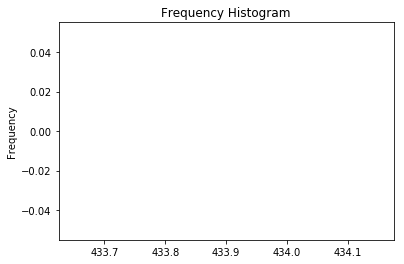

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


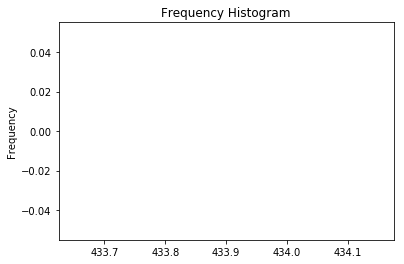

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


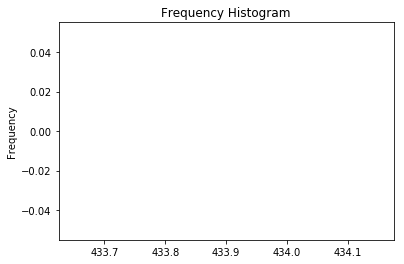

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


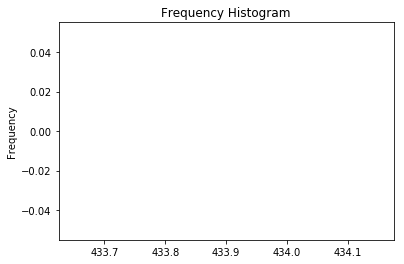

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


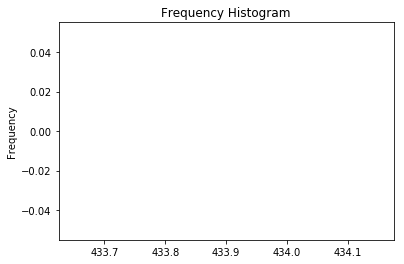

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


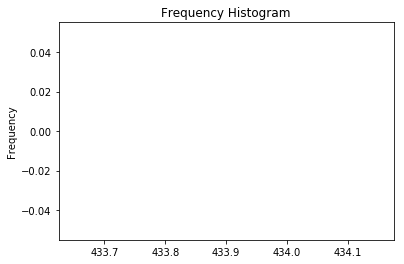

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


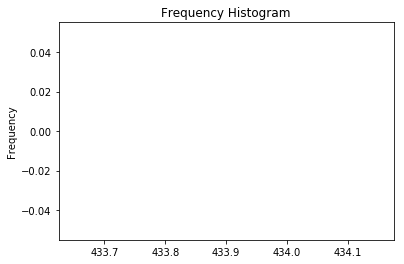

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


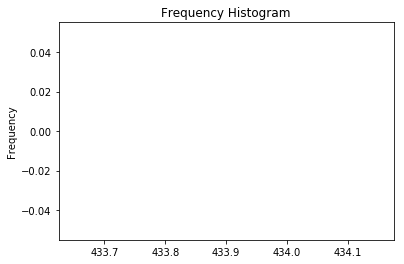

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


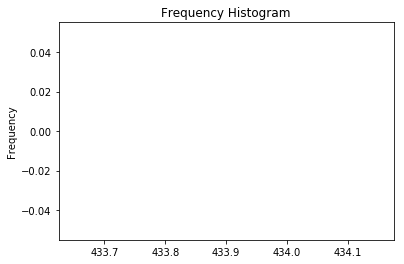

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


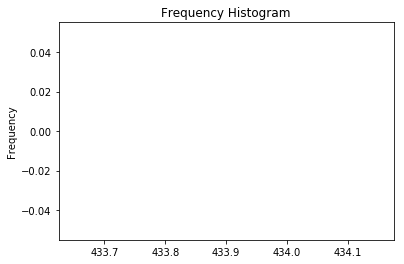

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************


In [51]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_noise)
print('type of file = ', type(data_IQ_list_val))
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_1msps.csv", histogram, delimiter=",")

inference file name =  click_fob1_50dBm_test10.sigmf-meta
inference file name =  click_fob1_50dBm_test6.sigmf-meta
inference file name =  click_fob1_50dBm_test7.sigmf-meta
inference file name =  click_fob1_50dBm_test8.sigmf-meta
inference file name =  click_fob1_50dBm_test9.sigmf-meta
inference file name =  click_fob1_60dBm_test1.sigmf-meta
inference file name =  click_fob1_60dBm_test2.sigmf-meta
inference file name =  click_fob1_60dBm_test3.sigmf-meta
inference file name =  click_fob1_60dBm_test4.sigmf-meta
inference file name =  click_fob1_60dBm_test5.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    234.29
std Freq =    216.14
length of inputs =  174


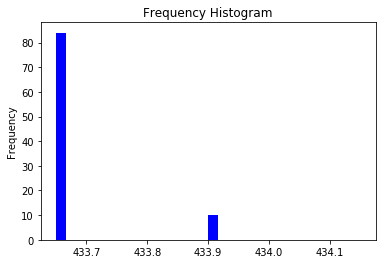

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.00%
clickndig = 0.97%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  80
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    186.92
std Freq =    214.76
length of inputs =  174


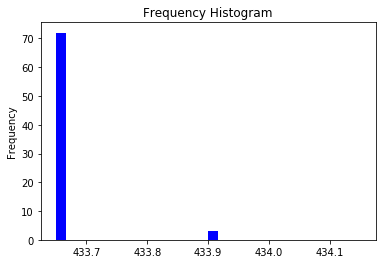

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.04
Vodeson Doorbell = 0.00%
clickndig = 0.96%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  99
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    348.99
std Freq =    171.98
length of inputs =  174


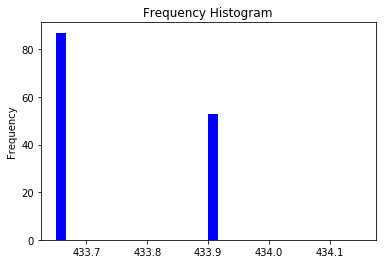

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.04
Vodeson Doorbell = 0.00%
clickndig = 0.96%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  34
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    199.38
std Freq =    216.12
length of inputs =  174


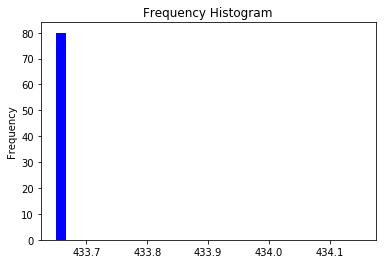

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  94
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    171.96
std Freq =    212.13
length of inputs =  174


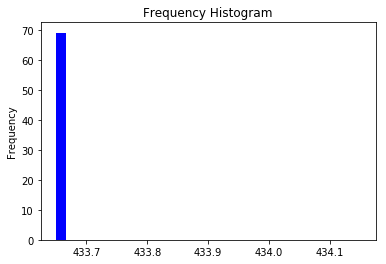

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.99%
Sado doorbell = 0.01%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  105
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


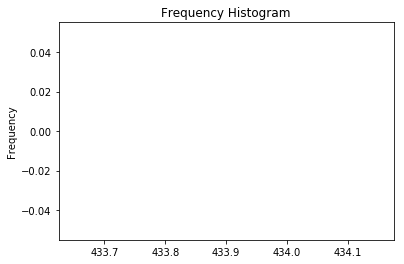

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =     24.92
std Freq =    100.93
length of inputs =  174


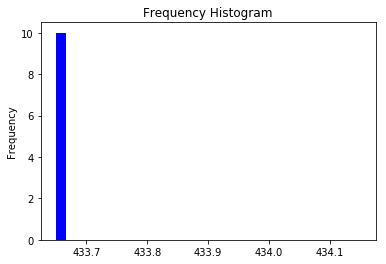

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 1.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  164
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


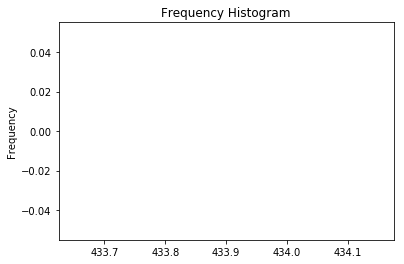

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


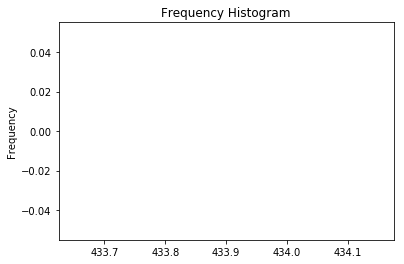

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =      0.00
std Freq =      0.00
length of inputs =  174


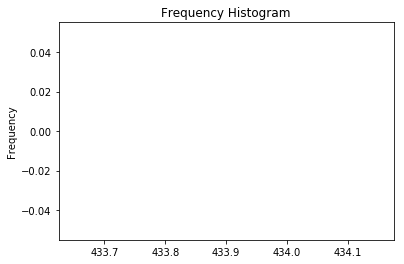

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  174
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 0 6 0 0 0 0]


In [52]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_1msps.csv", histogram, delimiter=",")
c = 5
final_data[c,:] = pick(c,histogram)

inference file name =  GD55_DMR_60dBm_test1.sigmf-meta
inference file name =  GD55_DMR_60dBm_test10.sigmf-meta
inference file name =  GD55_DMR_60dBm_test2.sigmf-meta
inference file name =  GD55_DMR_60dBm_test3.sigmf-meta
inference file name =  GD55_DMR_60dBm_test4.sigmf-meta
inference file name =  GD55_DMR_60dBm_test5.sigmf-meta
inference file name =  GD55_DMR_60dBm_test6.sigmf-meta
inference file name =  GD55_DMR_60dBm_test7.sigmf-meta
inference file name =  GD55_DMR_60dBm_test8.sigmf-meta
inference file name =  GD55_DMR_60dBm_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


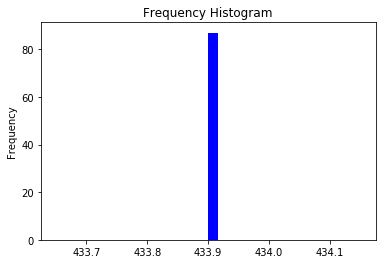

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


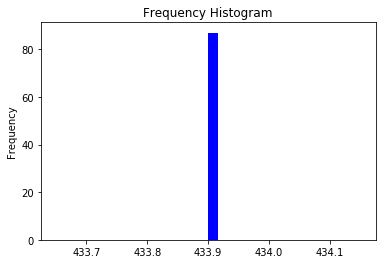

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.99%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


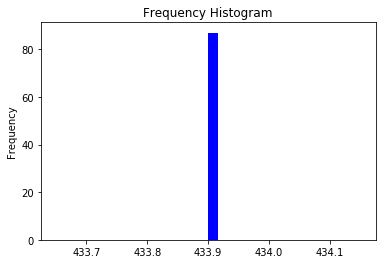

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


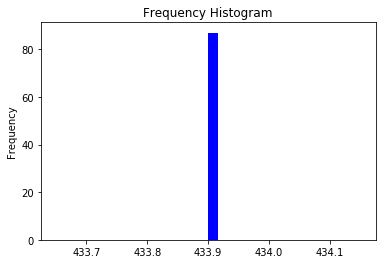

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.94%
NFM = 0.06%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


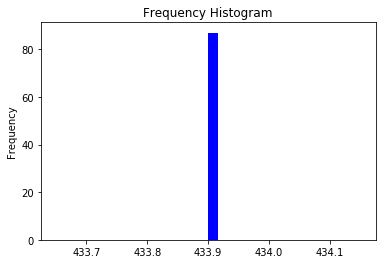

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.03%
NFM = 0.97%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


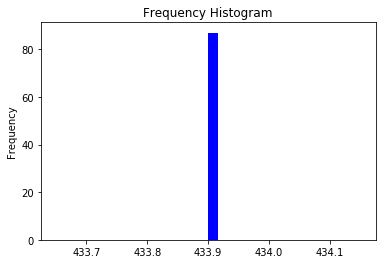

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.97%
NFM = 0.03%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


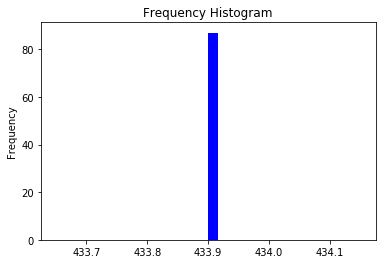

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.98%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


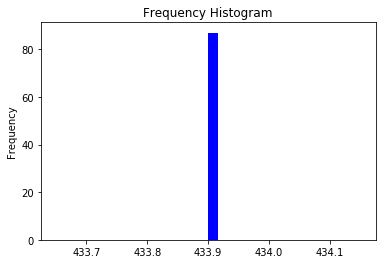

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.97%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


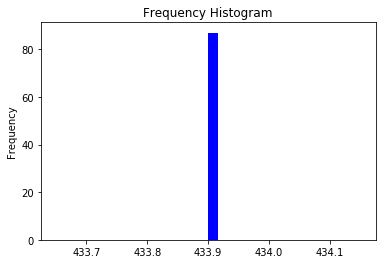

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.94%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.06%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


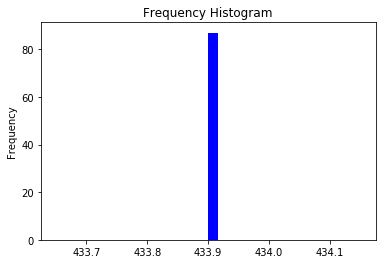

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.87%
NFM = 0.11%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 9 1 0 0 0 0 0 0 0]


In [53]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_1msps.csv", histogram, delimiter=",")
c = 1
final_data[c,:] = pick(c,histogram)

inference file name =  sw1_915_test1_on.sigmf-meta
inference file name =  sw1_915_test2_on.sigmf-meta
inference file name =  sw1_915_test3_on.sigmf-meta
inference file name =  sw1_915_test4_off.sigmf-meta
inference file name =  sw1_915_test5_off.sigmf-meta
inference file name =  sw1_915_test6_off.sigmf-meta
inference file name =  sw2_915_test1_on.sigmf-meta
inference file name =  sw2_915_test2_on.sigmf-meta
inference file name =  sw2_915_test3_on.sigmf-meta
inference file name =  sw2_915_test4_off.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


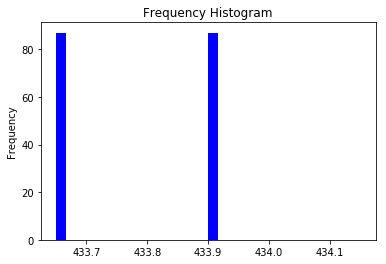

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.10%
LoRa 250 = 0.00%
light switch = 0.90%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


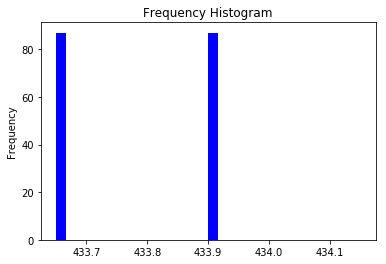

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.03%
LoRa 250 = 0.00%
light switch = 0.97%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


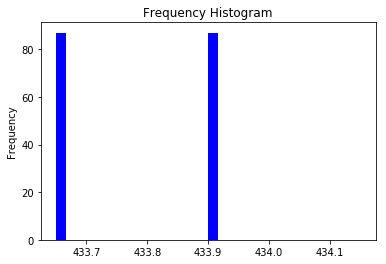

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.09%
LoRa 250 = 0.00%
light switch = 0.91%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


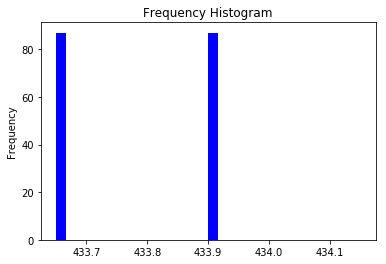

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


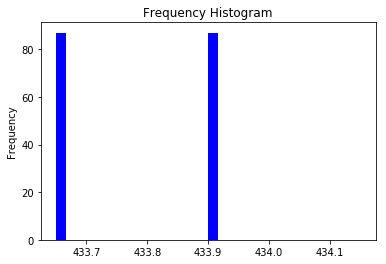

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


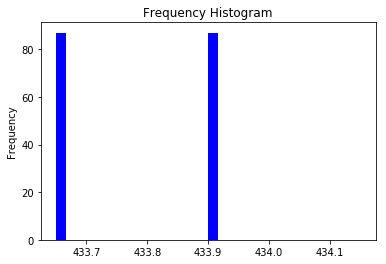

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.04%
LoRa 250 = 0.00%
light switch = 0.96%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    431.28
std Freq =     32.79
length of inputs =  174


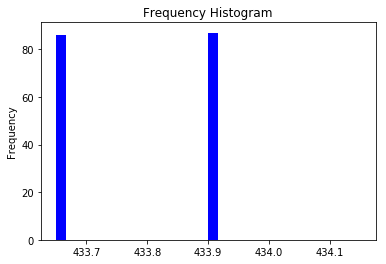

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.16%
LoRa 250 = 0.00%
light switch = 0.84%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


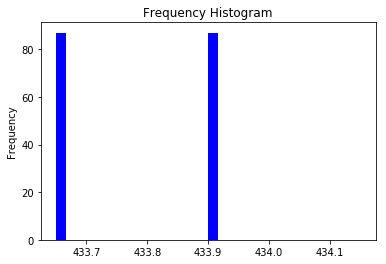

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


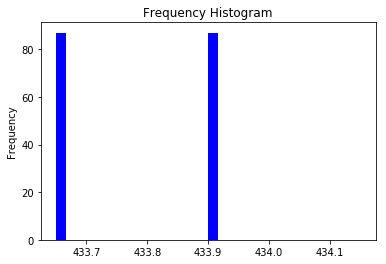

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.05%
LoRa 250 = 0.00%
light switch = 0.95%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


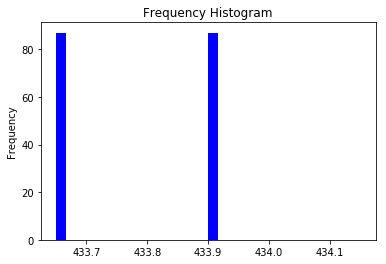

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 1.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0  0 10  0]


In [54]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_1msps.csv", histogram, delimiter=",")
c = 8
final_data[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    219.44
std Freq =    216.93
length of inputs =  174


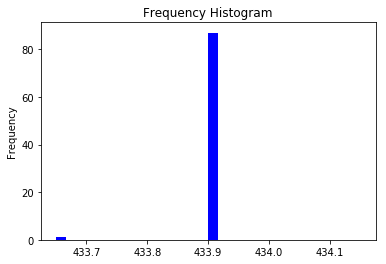

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  86
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    413.84
std Freq =     90.85
length of inputs =  174


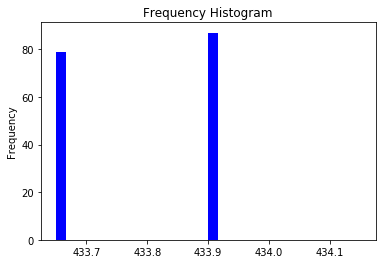

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.52%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.40%
Sado doorbell = 0.03%
LoRa 250 = 0.04%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  8
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    219.44
std Freq =    216.93
length of inputs =  174


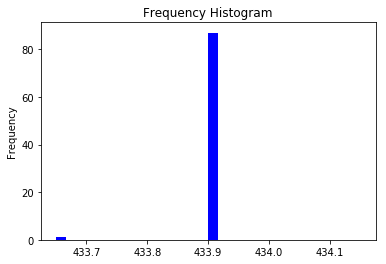

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  86
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


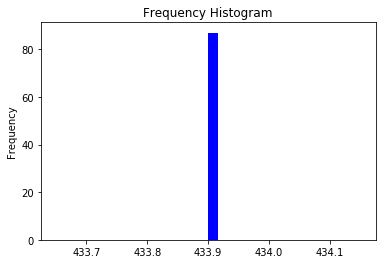

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 1.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    219.44
std Freq =    216.93
length of inputs =  174


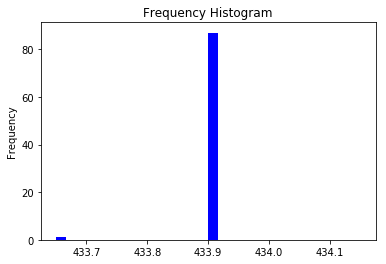

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  86
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    219.44
std Freq =    216.93
length of inputs =  174


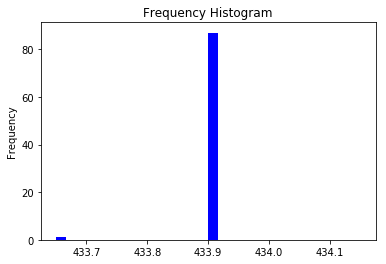

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  86
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    219.44
std Freq =    216.93
length of inputs =  174


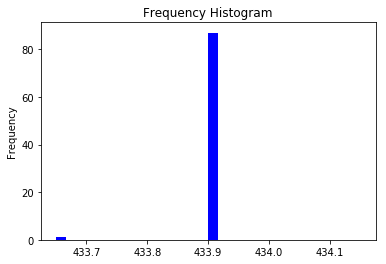

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.99%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.01
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  86
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


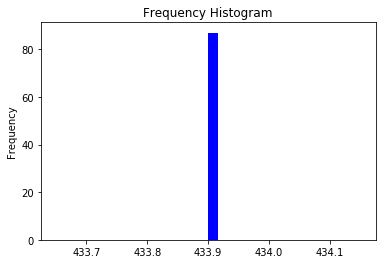

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.07%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.10%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.83%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    221.93
std Freq =    216.89
length of inputs =  174


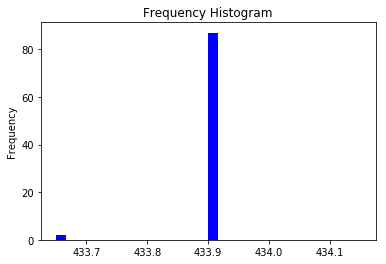

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.42%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.56%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  85
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    284.24
std Freq =    206.21
length of inputs =  174


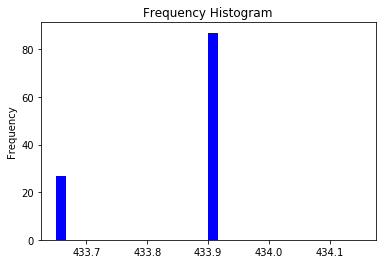

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.68%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.14%
Sado doorbell = 0.02%
LoRa 250 = 0.08%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  60
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [8 0 0 0 0 0 0 0 2 0]


In [55]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_1msps.csv", histogram, delimiter=",")
c = 0
final_data[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    393.90
std Freq =    125.35
length of inputs =  174


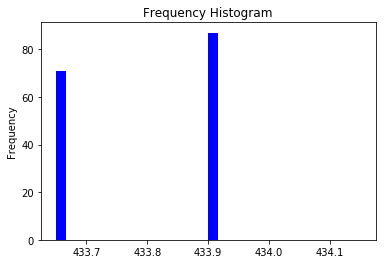

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.99%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  16
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    391.41
std Freq =    128.80
length of inputs =  174


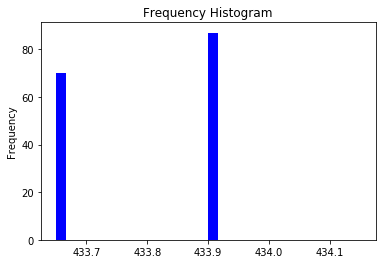

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.99%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  17
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    403.87
std Freq =    109.92
length of inputs =  174


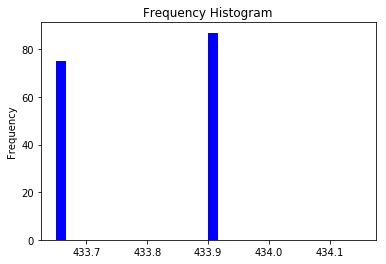

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.00%
LoRa 250 = 0.96%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  12
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    418.82
std Freq =     79.15
length of inputs =  174


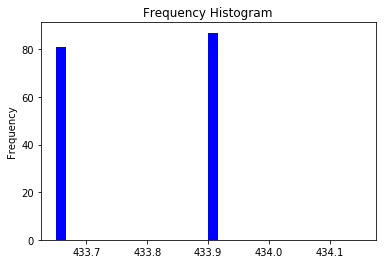

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.00%
LoRa 250 = 0.96%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  6
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    359.01
std Freq =    163.86
length of inputs =  174


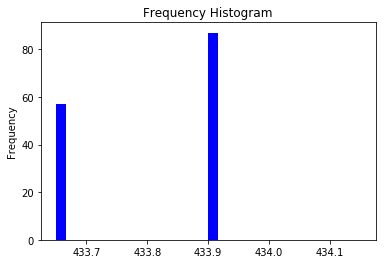

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.07%
Sado doorbell = 0.00%
LoRa 250 = 0.93%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  30
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    408.85
std Freq =    100.96
length of inputs =  174


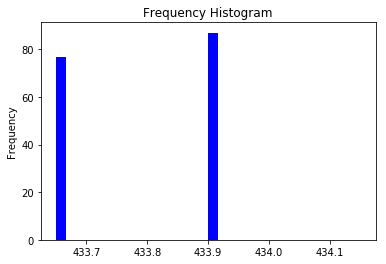

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.98%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  10
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    391.41
std Freq =    128.80
length of inputs =  174


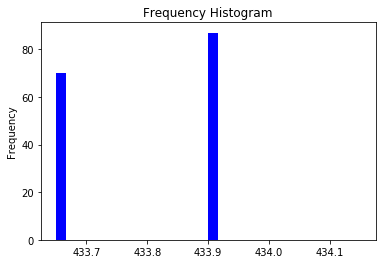

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.00%
LoRa 250 = 0.97%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  17
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    393.90
std Freq =    125.35
length of inputs =  174


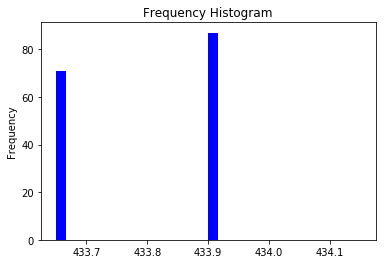

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.00%
LoRa 250 = 0.96%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  16
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    406.36
std Freq =    105.56
length of inputs =  174


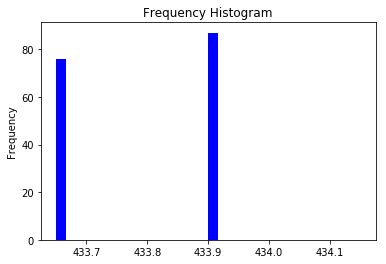

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.00%
LoRa 250 = 0.94%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  11
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    336.58
std Freq =    180.91
length of inputs =  174


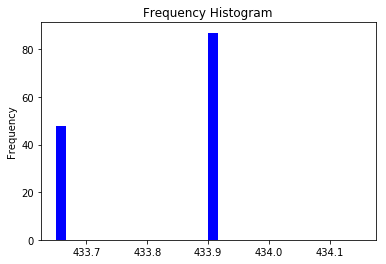

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.00%
LoRa 250 = 0.99%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  39
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0 10  0  0]


In [56]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_1msps.csv", histogram, delimiter=",")
c = 7
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_music2_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_music2_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


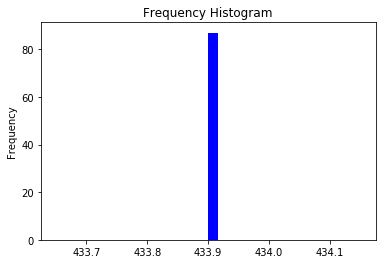

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


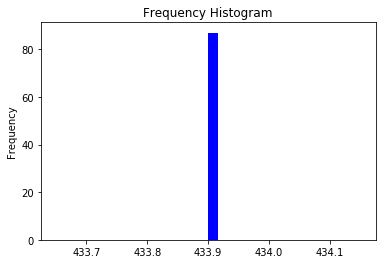

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


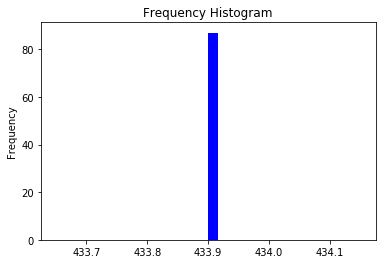

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


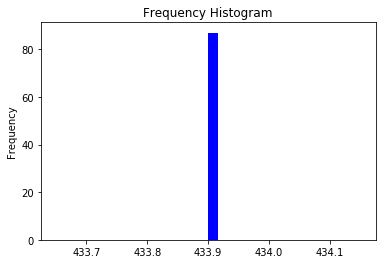

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


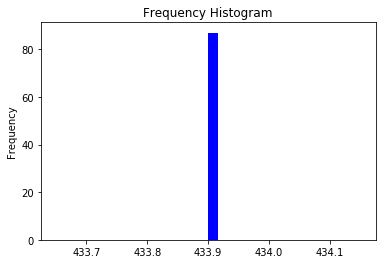

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


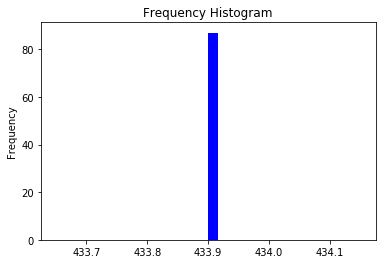

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


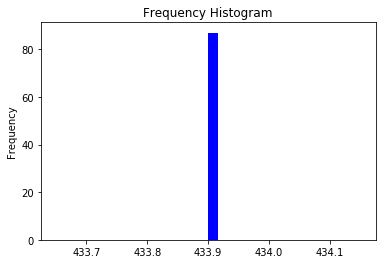

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


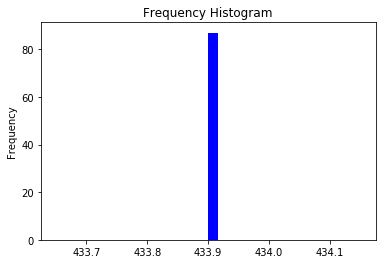

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


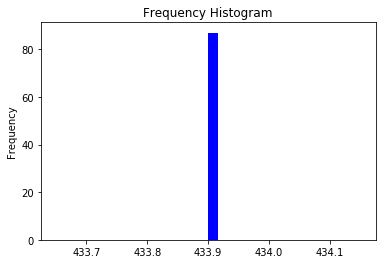

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


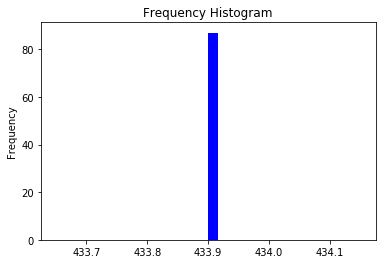

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0 10  0  0  0  0  0  0  0]


In [57]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_nfm)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_1msps.csv", histogram, delimiter=",")
c = 2
final_data[c,:] = pick(c,histogram)

inference file name =  sado_db1_50dBm_test10.sigmf-meta
inference file name =  sado_db1_50dBm_test6.sigmf-meta
inference file name =  sado_db1_50dBm_test7.sigmf-meta
inference file name =  sado_db1_50dBm_test8.sigmf-meta
inference file name =  sado_db1_50dBm_test9.sigmf-meta
inference file name =  sado_db1_60dBm_test1.sigmf-meta
inference file name =  sado_db1_60dBm_test2.sigmf-meta
inference file name =  sado_db1_60dBm_test3.sigmf-meta
inference file name =  sado_db1_60dBm_test4.sigmf-meta
inference file name =  sado_db1_60dBm_test5.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


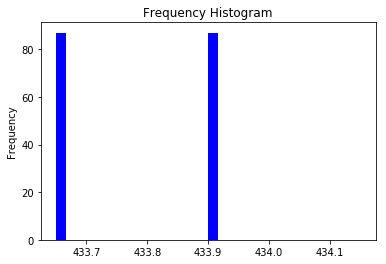

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    356.49
std Freq =    165.98
length of inputs =  174


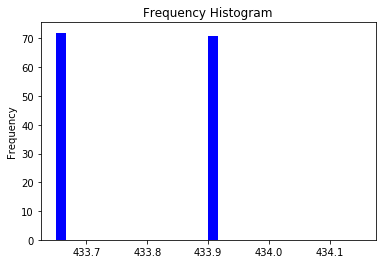

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  31
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


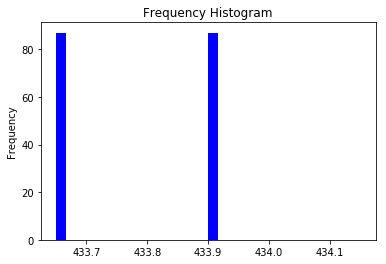

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


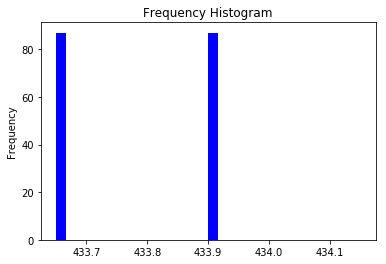

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    433.78
std Freq =      0.12
length of inputs =  174


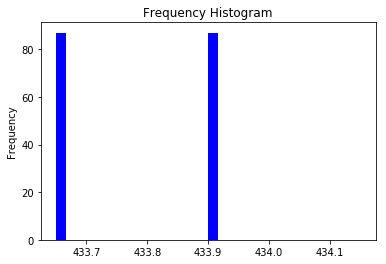

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


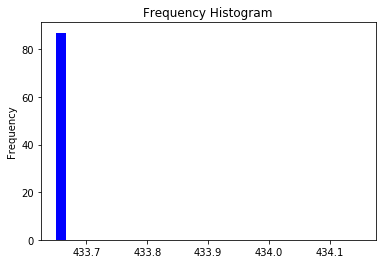

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


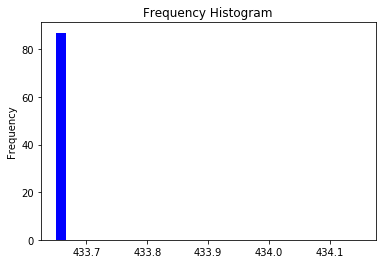

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


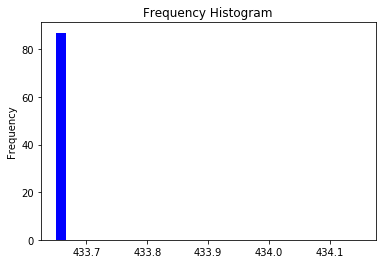

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.83
std Freq =    216.83
length of inputs =  174


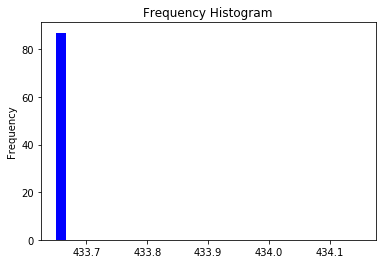

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    214.33
std Freq =    216.81
length of inputs =  174


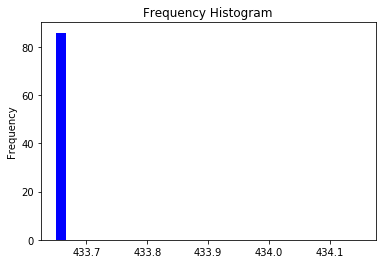

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  88
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [58]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_1msps.csv", histogram, delimiter=",")
c = 6
final_data[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_voice2_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_voice2_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


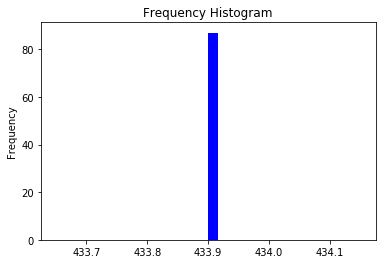

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


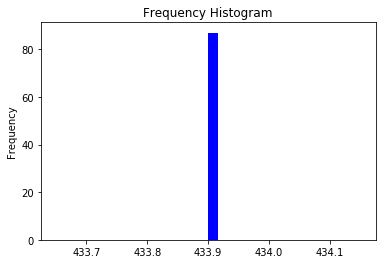

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


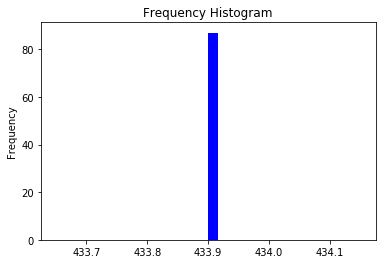

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


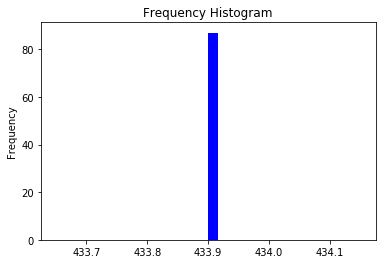

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


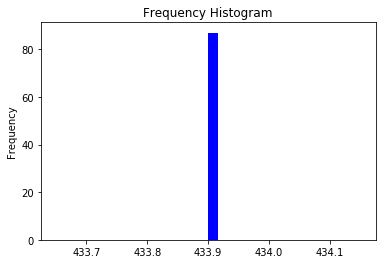

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


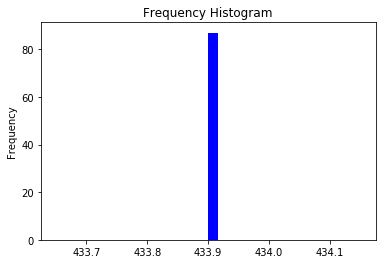

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


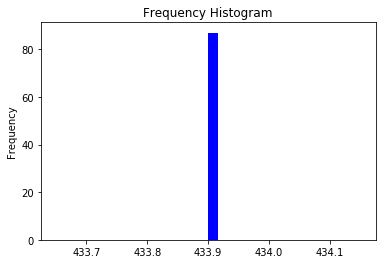

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


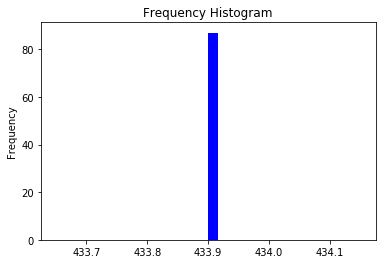

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


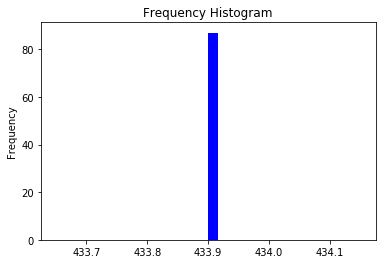

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


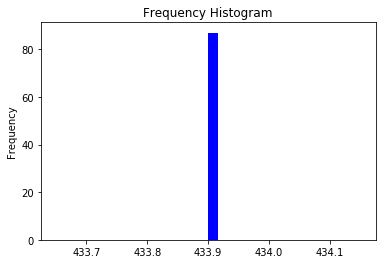

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0 10  0  0  0  0  0  0]


In [59]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_1msps.csv", histogram, delimiter=",")
c = 3
final_data[c,:] = pick(c,histogram)

inference file name =  vod_50dBm_test10.sigmf-meta
inference file name =  vod_50dBm_test6.sigmf-meta
inference file name =  vod_50dBm_test7.sigmf-meta
inference file name =  vod_50dBm_test8.sigmf-meta
inference file name =  vod_50dBm_test9.sigmf-meta
inference file name =  vod_60dBm_test1.sigmf-meta
inference file name =  vod_60dBm_test2.sigmf-meta
inference file name =  vod_60dBm_test3.sigmf-meta
inference file name =  vod_60dBm_test4.sigmf-meta
inference file name =  vod_60dBm_test5.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    147.13
std Freq =    205.41
length of inputs =  174


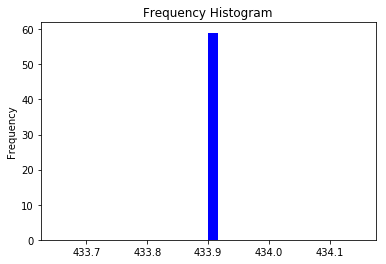

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.97%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  115
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    154.61
std Freq =    207.80
length of inputs =  174


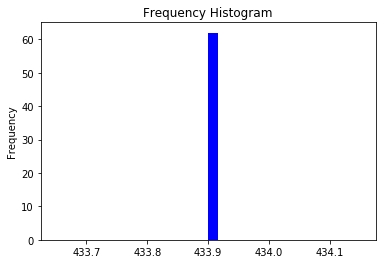

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.03
Vodeson Doorbell = 0.97%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  112
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    144.63
std Freq =    204.54
length of inputs =  174


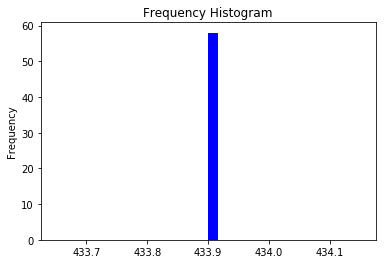

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.98%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  116
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    157.10
std Freq =    208.53
length of inputs =  174


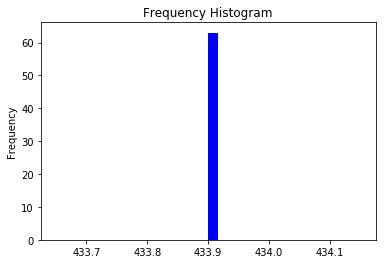

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.05
Vodeson Doorbell = 0.95%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  111
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    162.09
std Freq =    209.90
length of inputs =  174


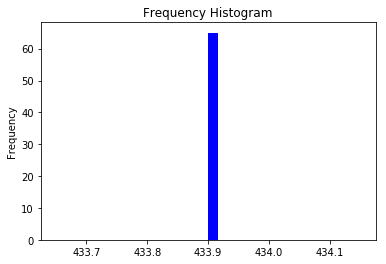

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.05
Vodeson Doorbell = 0.95%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  109
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =     79.80
std Freq =    168.10
length of inputs =  174


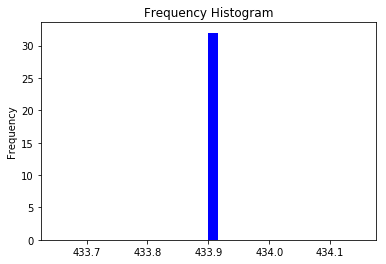

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.09
Vodeson Doorbell = 0.88%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.03%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  111
center fft matches =  31
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    132.16
std Freq =    199.70
length of inputs =  174


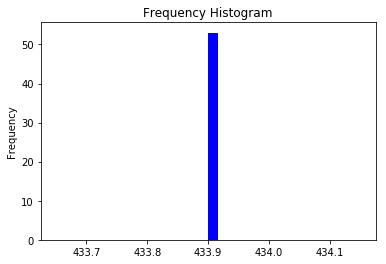

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.06
Vodeson Doorbell = 0.94%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  121
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    124.68
std Freq =    196.35
length of inputs =  174


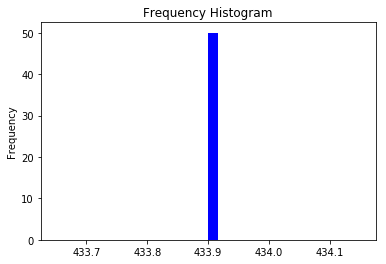

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.06
Vodeson Doorbell = 0.90%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.04%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  108
center fft matches =  16
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =     62.34
std Freq =    152.20
length of inputs =  174


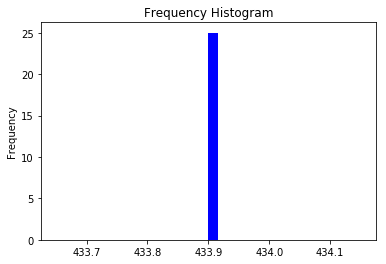

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.12
Vodeson Doorbell = 0.36%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.52%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  109
center fft matches =  40
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =     49.87
std Freq =    138.39
length of inputs =  174


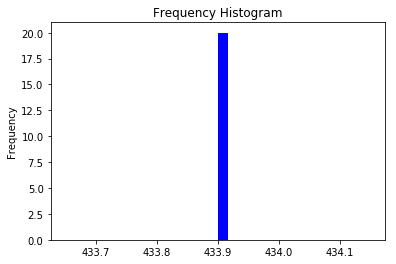

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.10
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.90%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  110
center fft matches =  44
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 8 0 0 0 0 2]


In [60]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_1msps.csv", histogram, delimiter=",")
c = 4
final_data[c,:] = pick(c,histogram)

inference file name =  YSF4_1msps_test1.sigmf-meta
inference file name =  YSF4_1msps_test10.sigmf-meta
inference file name =  YSF4_1msps_test2.sigmf-meta
inference file name =  YSF4_1msps_test3.sigmf-meta
inference file name =  YSF4_1msps_test4.sigmf-meta
inference file name =  YSF4_1msps_test5.sigmf-meta
inference file name =  YSF4_1msps_test6.sigmf-meta
inference file name =  YSF4_1msps_test7.sigmf-meta
inference file name =  YSF4_1msps_test8.sigmf-meta
inference file name =  YSF4_1msps_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


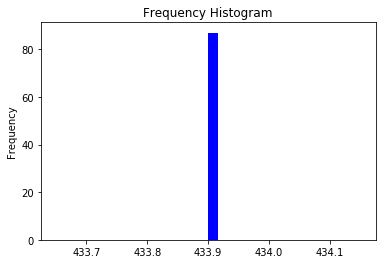

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


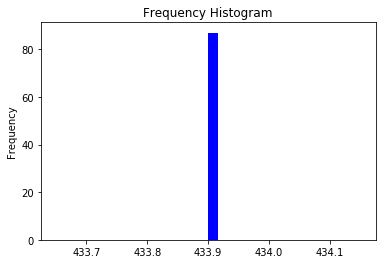

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


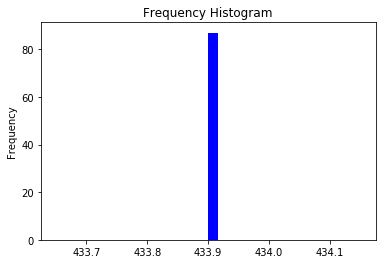

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


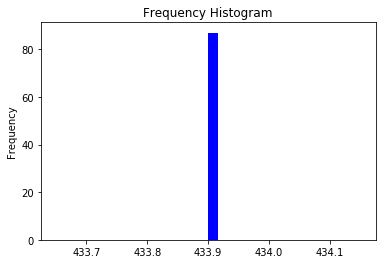

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


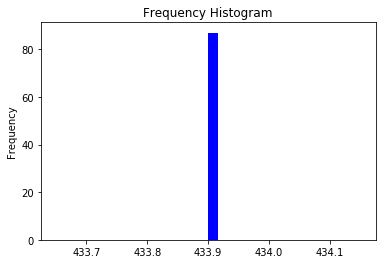

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


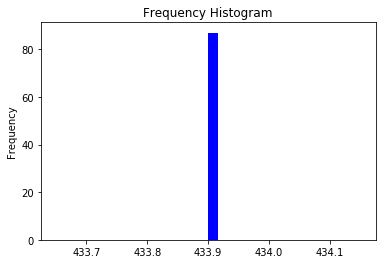

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


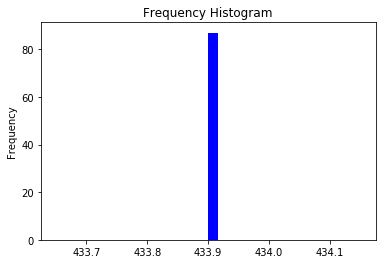

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


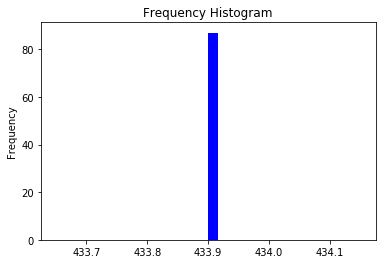

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


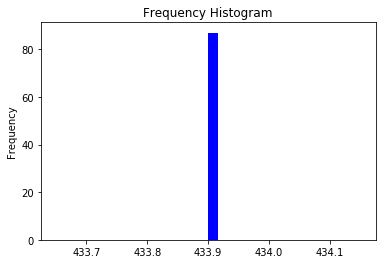

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([493, 19532, 4])
start_frequency =  433.65
mean Freq =    216.95
std Freq =    216.95
length of inputs =  174


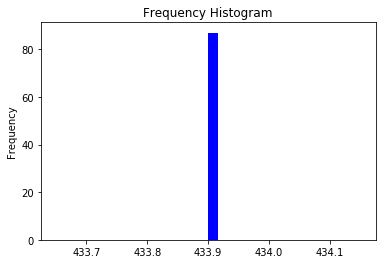

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0  0  0 10]


In [61]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_1msps.csv", histogram, delimiter=",")
c = 9
final_data[c,:] = pick(c,histogram)

In [62]:
final_data = final_data.astype(int)
final_data

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  9,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [63]:
np.trace(final_data)

91

In [64]:
os.chdir(path_confuse)
np.savetxt("ResNet50_20220210_1msps_train_score_1msps_data_1classes.csv", final_data, delimiter=",")

#### 5msps

In [65]:
final_data_5msps = np.zeros((10,10))

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


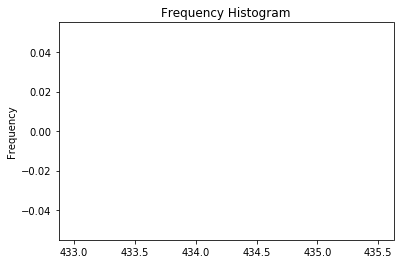

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


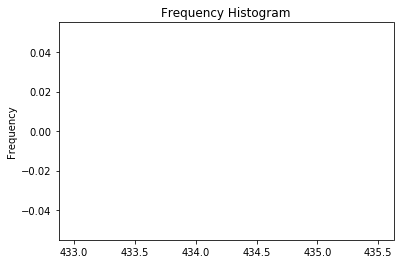

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


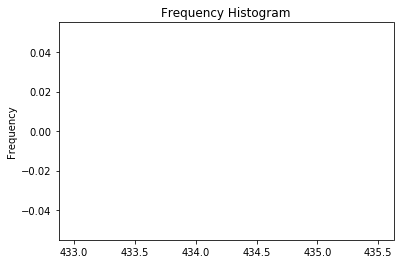

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


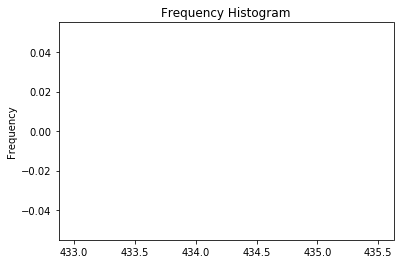

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


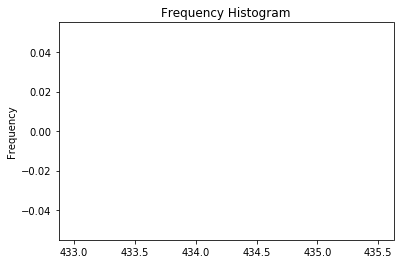

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


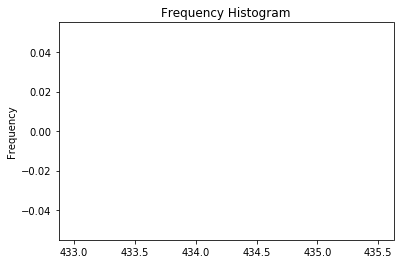

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


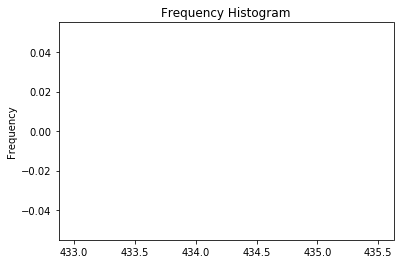

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


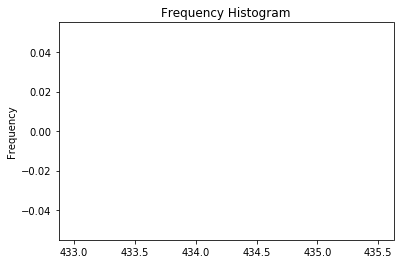

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


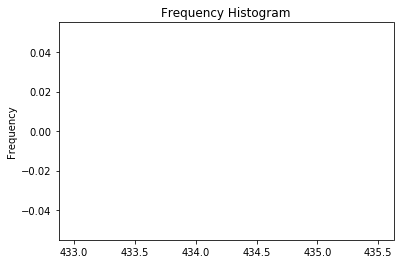

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


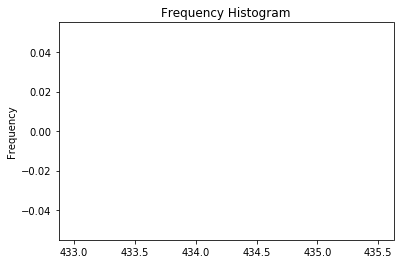

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [66]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_5msps.csv", histogram, delimiter=",")

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


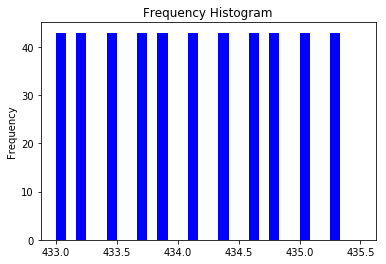

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


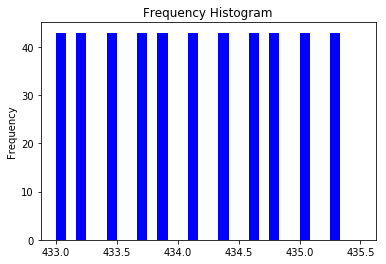

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


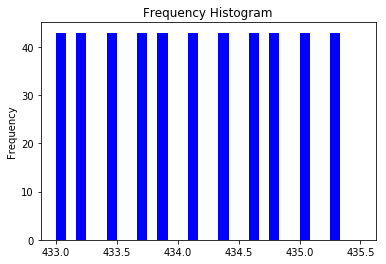

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


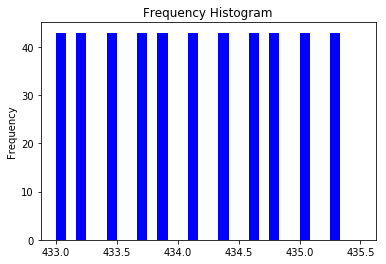

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


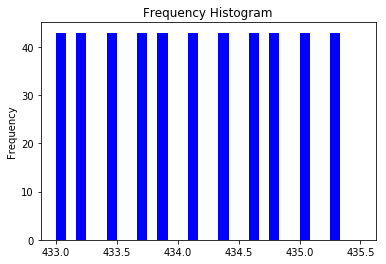

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


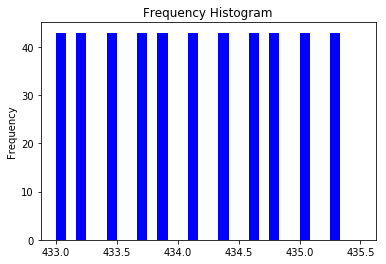

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


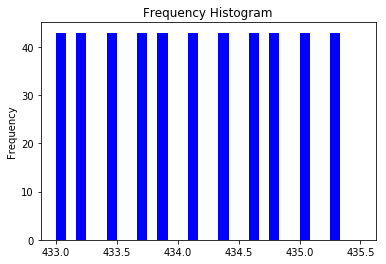

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


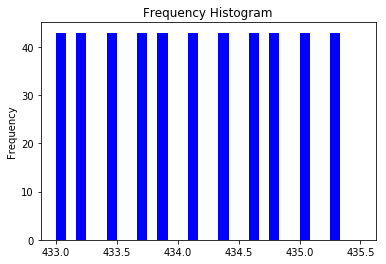

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


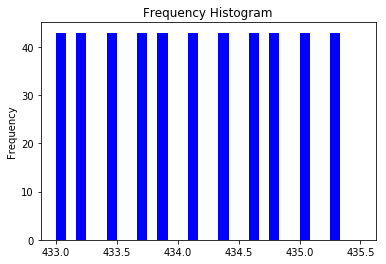

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


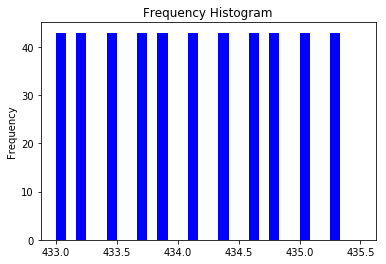

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]
Cycle time =  30.40956099901814


In [67]:
start = timer()
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_5msps.csv", histogram, delimiter=",")
c = 5
final_data_5msps[c,:] = pick(c,histogram)
end = timer()
total_time = end - start
print('Cycle time = ', total_time)

inference file name =  UHF_GD55_DMR_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    400.20
std Freq =    116.58
length of inputs =  473


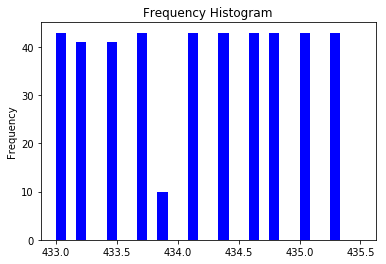

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.00%
LoRa 250 = 0.96%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  37
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


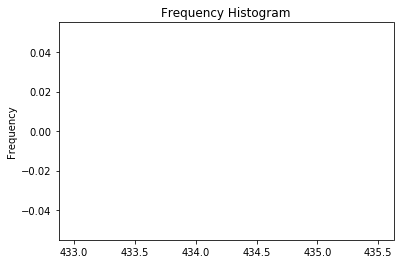

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.92
std Freq =     19.93
length of inputs =  473


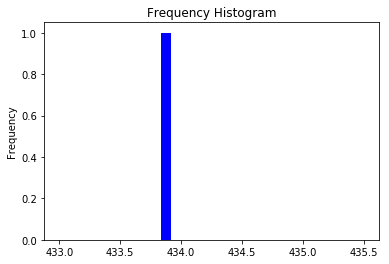

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 1.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  472
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


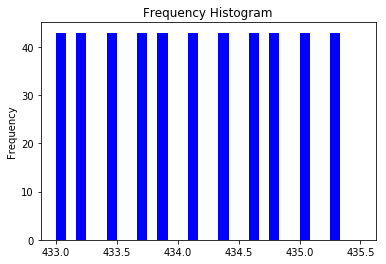

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.89%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


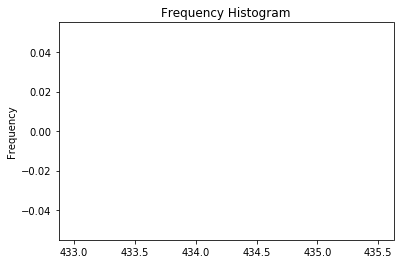

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    433.22
std Freq =     19.95
length of inputs =  473


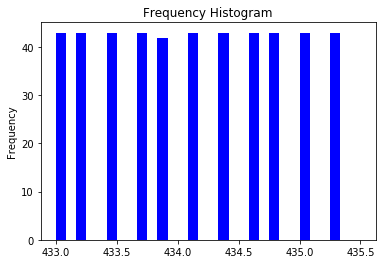

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.07%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      3.67
std Freq =     39.73
length of inputs =  473


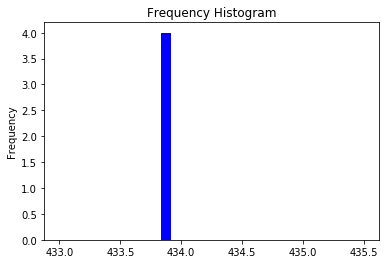

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.25%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.75%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  469
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    413.96
std Freq =     91.43
length of inputs =  473


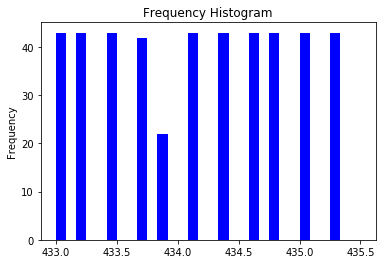

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.00%
LoRa 250 = 0.94%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  22
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  473


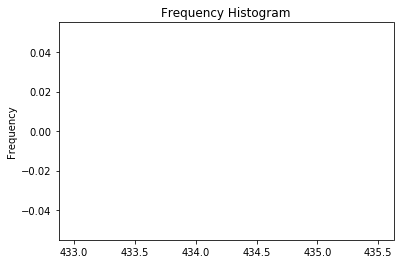

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  473
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    423.13
std Freq =     68.27
length of inputs =  473


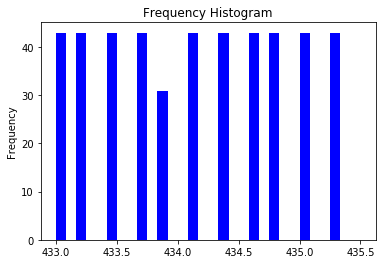

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.00%
LoRa 250 = 0.92%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  12
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 1 0 0 0 0 0 5 0 1]


In [68]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_5msps.csv", histogram, delimiter=",")
c = 1
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  sw1_50dBm_test1.sigmf-meta
inference file name =  sw1_50dBm_test2.sigmf-meta
inference file name =  sw1_50dBm_test3.sigmf-meta
inference file name =  sw1_50dBm_test4.sigmf-meta
inference file name =  sw1_50dBm_test5.sigmf-meta
inference file name =  sw1_60dBm_test10.sigmf-meta
inference file name =  sw1_60dBm_test6.sigmf-meta
inference file name =  sw1_60dBm_test7.sigmf-meta
inference file name =  sw1_60dBm_test8.sigmf-meta
inference file name =  sw1_60dBm_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    303.57
std Freq =    198.83
length of inputs =  473


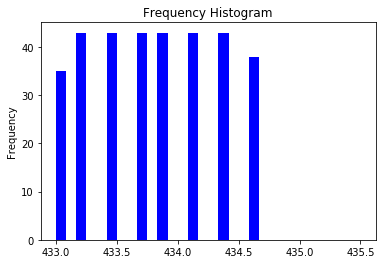

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.12%
Sado doorbell = 0.15%
LoRa 250 = 0.11%
light switch = 0.62%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  142
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    265.03
std Freq =    211.47
length of inputs =  473


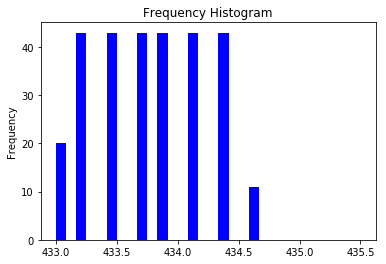

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.11%
Sado doorbell = 0.27%
LoRa 250 = 0.13%
light switch = 0.49%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  184
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    243.97
std Freq =    215.22
length of inputs =  473


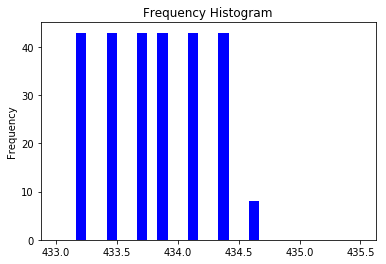

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.32%
LoRa 250 = 0.18%
light switch = 0.49%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  207
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    120.17
std Freq =    194.17
length of inputs =  473


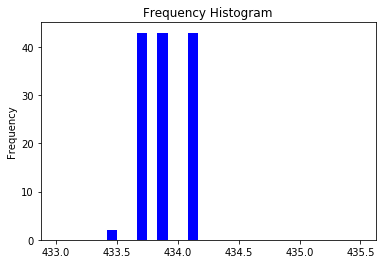

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.19%
LoRa 250 = 0.02%
light switch = 0.79%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  342
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    197.23
std Freq =    216.06
length of inputs =  473


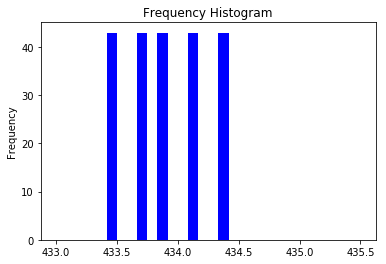

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.40%
LoRa 250 = 0.00%
light switch = 0.60%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  258
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    155.92
std Freq =    208.16
length of inputs =  473


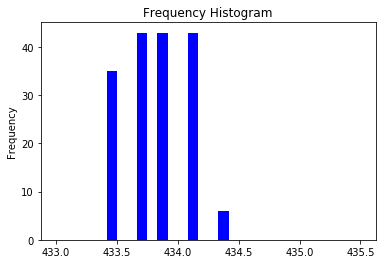

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.14%
Sado doorbell = 0.10%
LoRa 250 = 0.00%
light switch = 0.76%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  303
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    118.34
std Freq =    193.25
length of inputs =  473


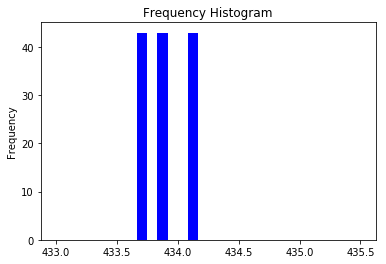

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.40%
LoRa 250 = 0.00%
light switch = 0.60%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  344
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    126.59
std Freq =    197.23
length of inputs =  473


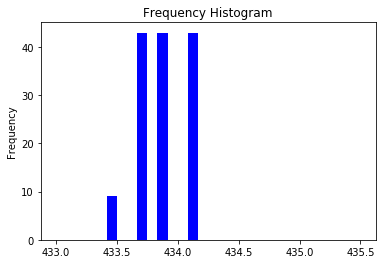

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.00%
LoRa 250 = 0.01%
light switch = 0.93%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  335
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    118.34
std Freq =    193.25
length of inputs =  473


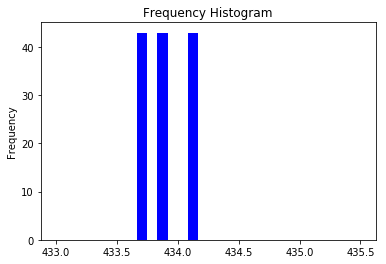

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.67%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  344
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    192.64
std Freq =    215.58
length of inputs =  473


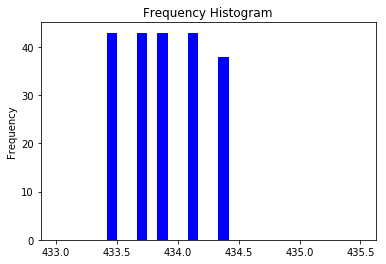

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.35%
LoRa 250 = 0.00%
light switch = 0.61%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  263
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0  0 10  0]


In [69]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_5msps.csv", histogram, delimiter=",")
c = 8
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


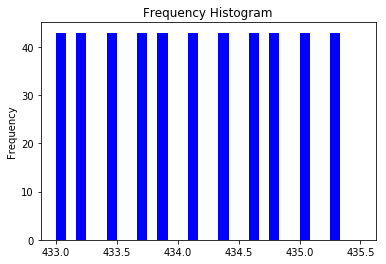

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.39%
Sado doorbell = 0.00%
LoRa 250 = 0.51%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


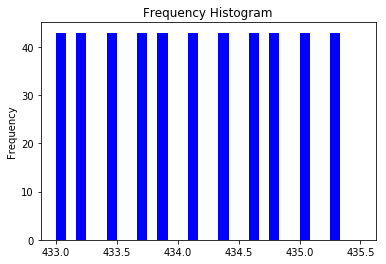

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.08%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.44%
Sado doorbell = 0.07%
LoRa 250 = 0.40%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


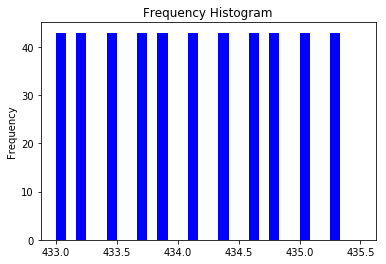

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.47%
Sado doorbell = 0.01%
LoRa 250 = 0.43%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


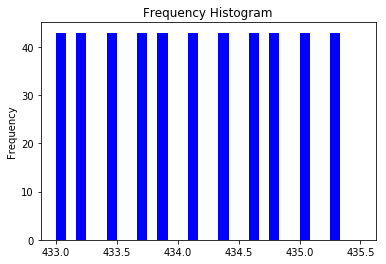

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.33%
Sado doorbell = 0.00%
LoRa 250 = 0.58%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


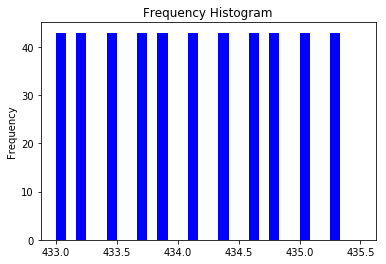

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.31%
Sado doorbell = 0.00%
LoRa 250 = 0.60%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


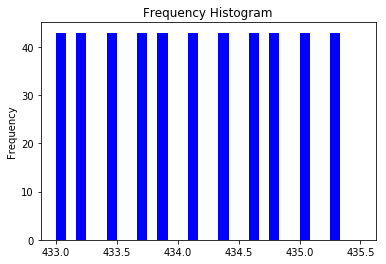

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.19%
Sado doorbell = 0.00%
LoRa 250 = 0.71%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


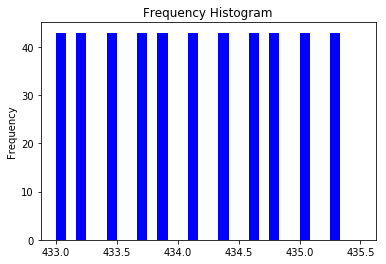

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.23%
Sado doorbell = 0.00%
LoRa 250 = 0.68%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


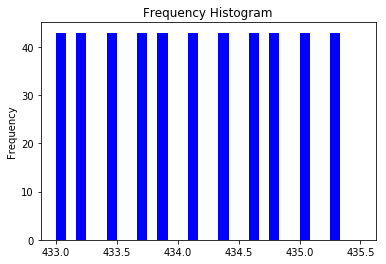

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.49%
Sado doorbell = 0.01%
LoRa 250 = 0.42%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


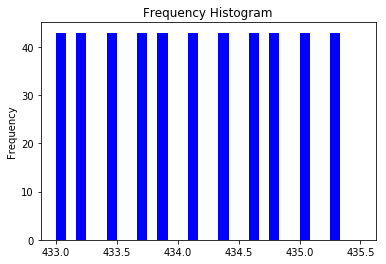

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.44%
Sado doorbell = 0.01%
LoRa 250 = 0.46%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


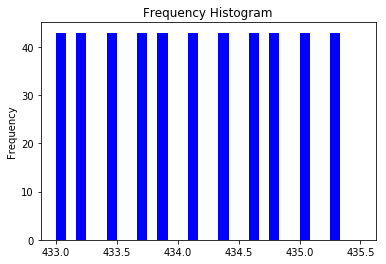

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.40%
Sado doorbell = 0.01%
LoRa 250 = 0.50%
light switch = 0.09%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 0 3 0 7 0 0]


In [70]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_5msps.csv", histogram, delimiter=",")
c = 0
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    432.30
std Freq =     28.18
length of inputs =  473


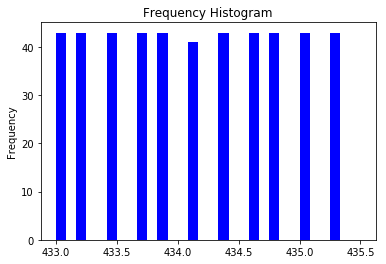

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.40%
Sado doorbell = 0.08%
LoRa 250 = 0.52%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


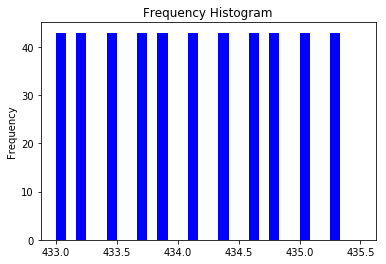

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.40%
Sado doorbell = 0.04%
LoRa 250 = 0.56%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


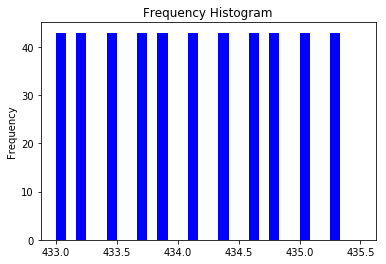

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.43%
Sado doorbell = 0.10%
LoRa 250 = 0.47%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    431.38
std Freq =     34.47
length of inputs =  473


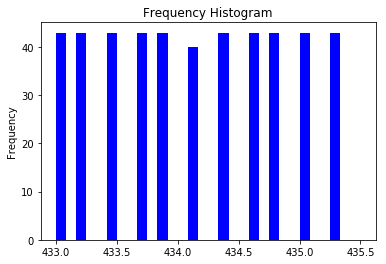

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.31%
Sado doorbell = 0.06%
LoRa 250 = 0.63%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  3
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


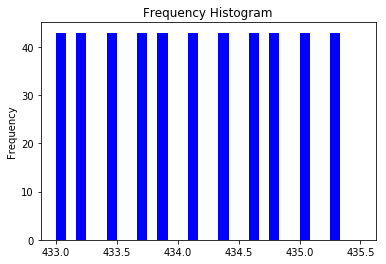

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.44%
Sado doorbell = 0.11%
LoRa 250 = 0.45%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


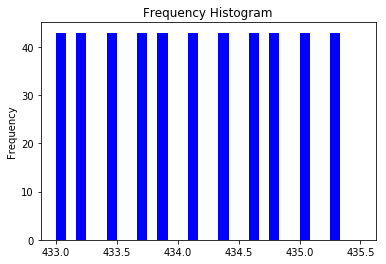

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.36%
Sado doorbell = 0.06%
LoRa 250 = 0.58%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


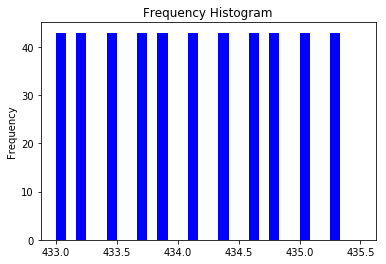

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.37%
Sado doorbell = 0.12%
LoRa 250 = 0.52%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


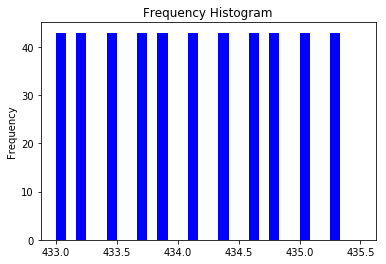

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.34%
Sado doorbell = 0.09%
LoRa 250 = 0.57%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


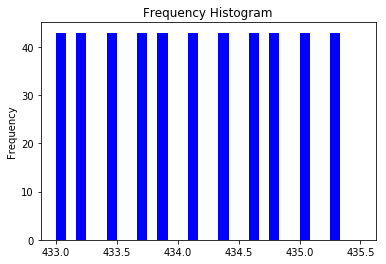

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.39%
Sado doorbell = 0.08%
LoRa 250 = 0.53%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


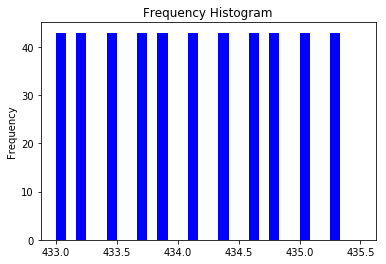

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.38%
Sado doorbell = 0.07%
LoRa 250 = 0.55%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0 10  0  0]


In [71]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_5msps.csv", histogram, delimiter=",")
c = 7
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_UV5R_voice_test1.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test10.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test2.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test3.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test4.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test5.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test6.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test7.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test8.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


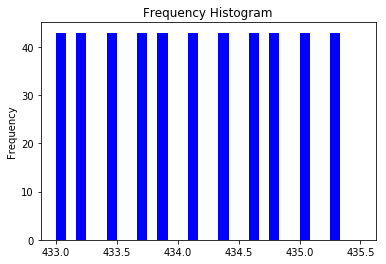

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.08%
Sado doorbell = 0.01%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    418.54
std Freq =     80.82
length of inputs =  473


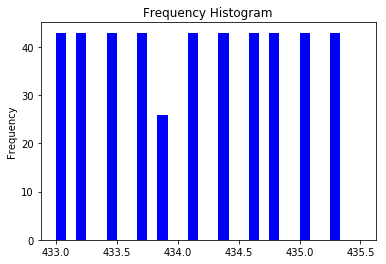

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.00%
LoRa 250 = 0.94%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  17
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


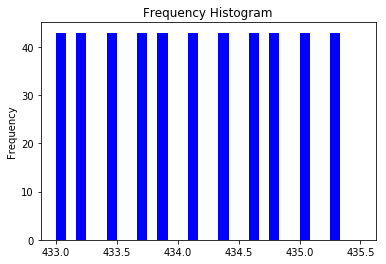

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.07%
Sado doorbell = 0.03%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    433.22
std Freq =     19.95
length of inputs =  473


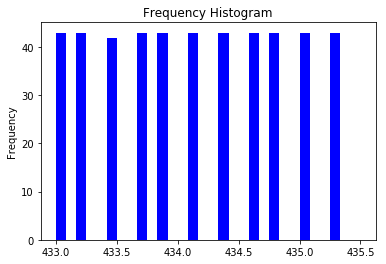

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


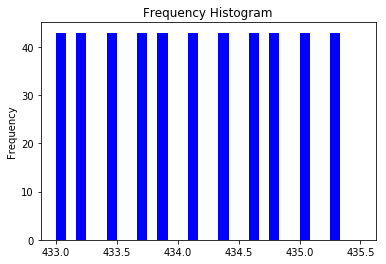

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    432.30
std Freq =     28.18
length of inputs =  473


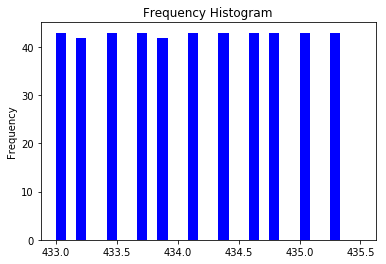

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    429.55
std Freq =     44.41
length of inputs =  473


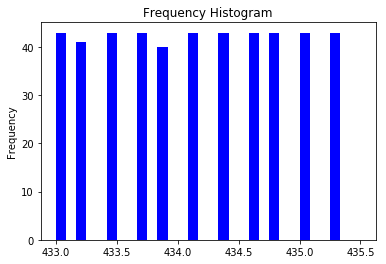

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  5
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    421.30
std Freq =     73.58
length of inputs =  473


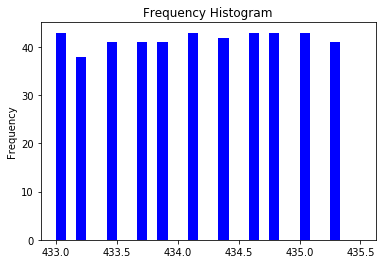

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  14
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    425.88
std Freq =     59.32
length of inputs =  473


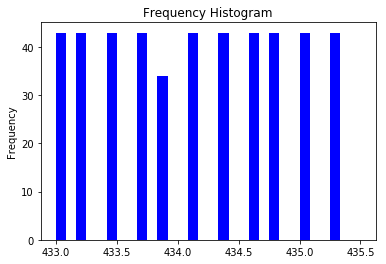

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  9
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    424.05
std Freq =     65.44
length of inputs =  473


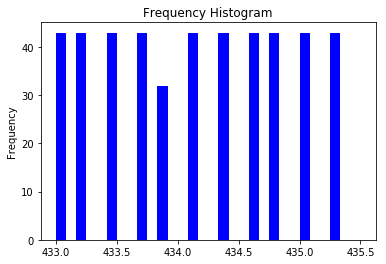

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.08%
Sado doorbell = 0.00%
LoRa 250 = 0.92%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  11
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0 10  0  0]


In [72]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_uv5r)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_5msps.csv", histogram, delimiter=",")
c = 2
final_data_5msps[c,:] = pick(c,histogram)

In [73]:
# msps = 5
# center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_vx8)
# histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()
# os.chdir(path_output4D)
# np.savetxt("vx8_5msps.csv", histogram, delimiter=",")
# c = 2
# final_data_5msps[c,:] = pick(c,histogram)

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


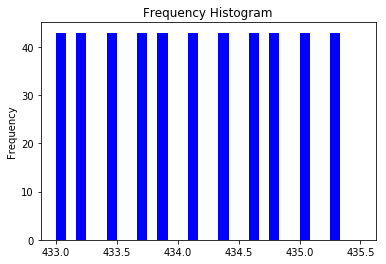

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


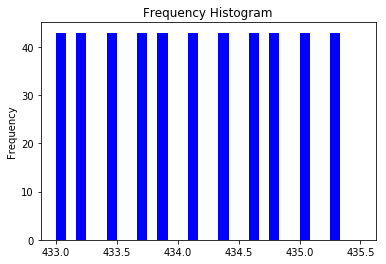

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


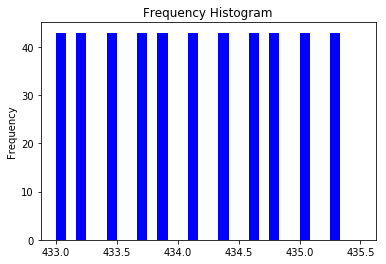

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


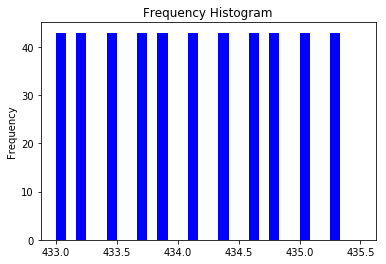

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.93%
LoRa 250 = 0.00%
light switch = 0.07%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


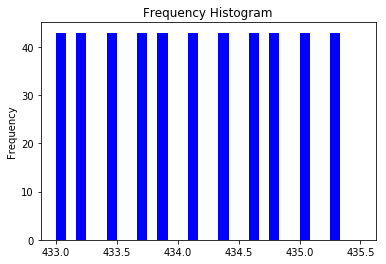

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


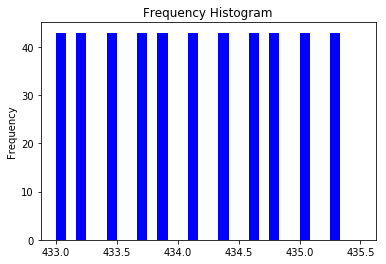

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


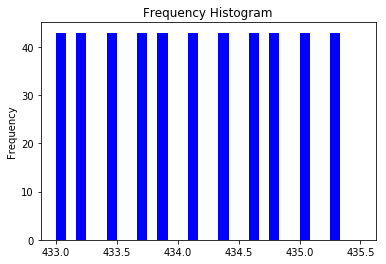

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.92%
LoRa 250 = 0.00%
light switch = 0.08%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


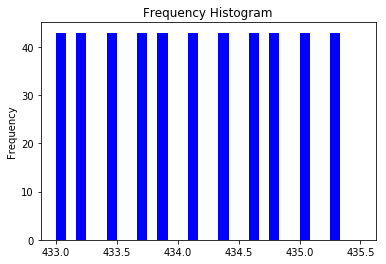

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


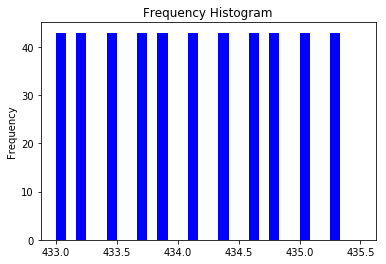

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


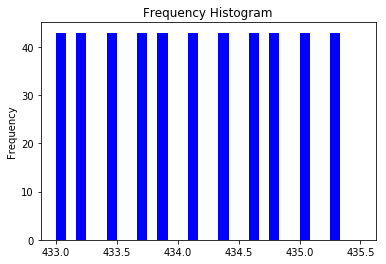

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [74]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_5msps.csv", histogram, delimiter=",")
c = 6
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    426.81
std Freq =     55.99
length of inputs =  473


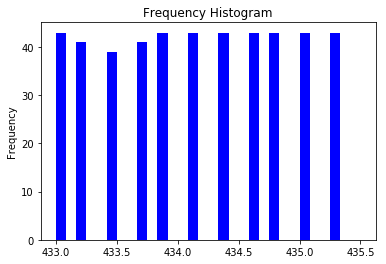

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  8
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      8.26
std Freq =     59.28
length of inputs =  473


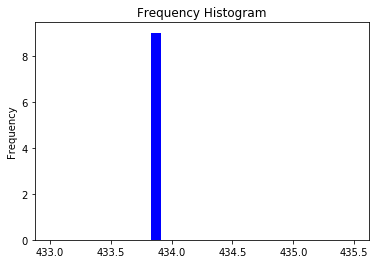

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  464
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     10.09
std Freq =     65.40
length of inputs =  473


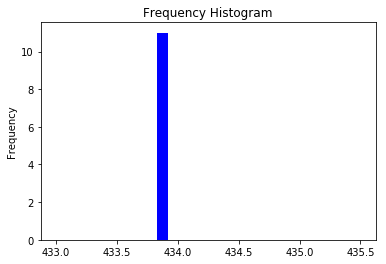

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  462
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


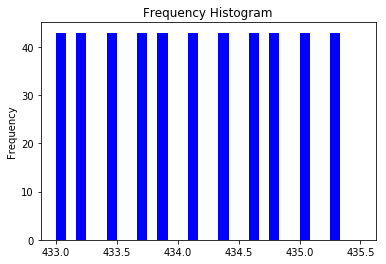

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     14.68
std Freq =     78.44
length of inputs =  473


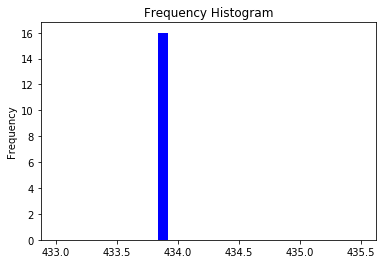

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  457
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


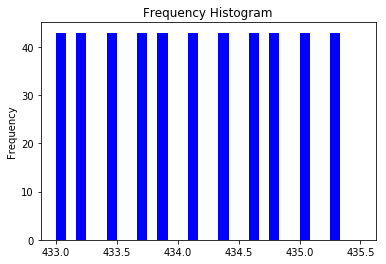

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      6.42
std Freq =     52.39
length of inputs =  473


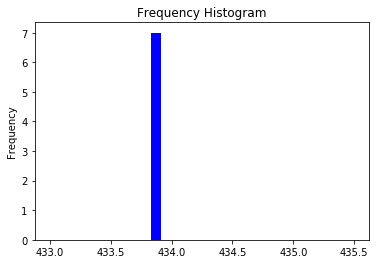

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  466
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    425.89
std Freq =     59.32
length of inputs =  473


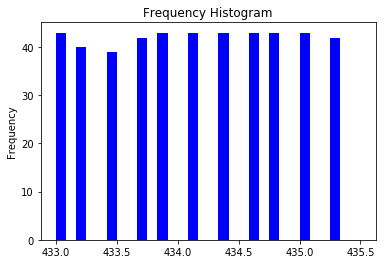

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.10%
Sado doorbell = 0.00%
LoRa 250 = 0.90%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  9
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =      3.67
std Freq =     39.73
length of inputs =  473


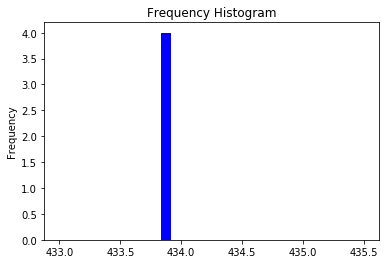

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  469
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


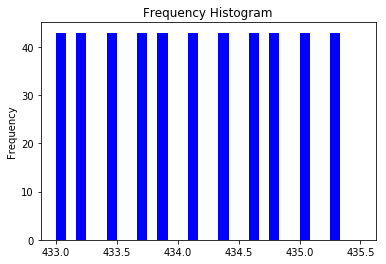

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 5 0 0 0 5 0 0]


In [75]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_5msps.csv", histogram, delimiter=",")
c = 3
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    431.38
std Freq =     34.47
length of inputs =  473


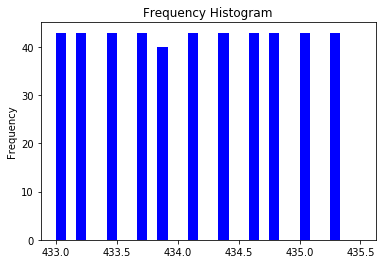

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.02%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  3
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


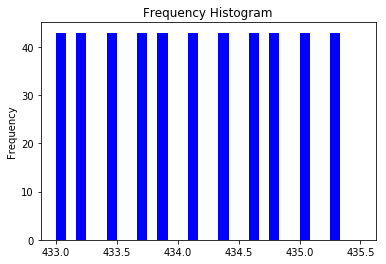

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    403.86
std Freq =    110.60
length of inputs =  473


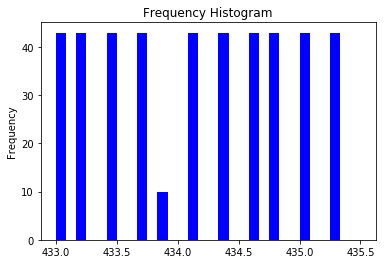

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  33
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    408.45
std Freq =    102.46
length of inputs =  473


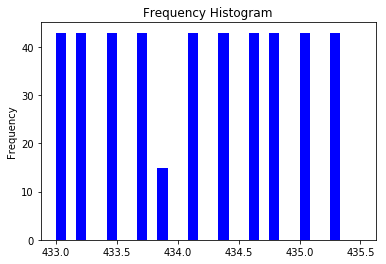

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  28
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    432.30
std Freq =     28.18
length of inputs =  473


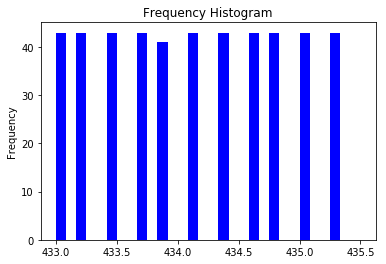

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.04%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  2
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    408.45
std Freq =    102.46
length of inputs =  473


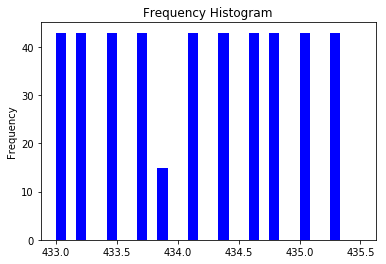

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  28
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    401.11
std Freq =    115.13
length of inputs =  473


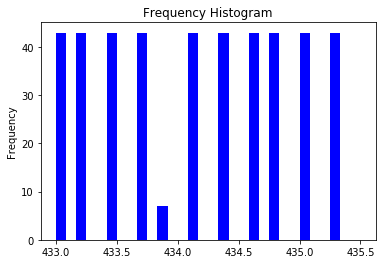

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  36
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    415.79
std Freq =     87.37
length of inputs =  473


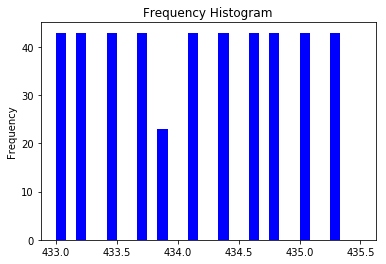

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.00%
Sado doorbell = 0.97%
LoRa 250 = 0.00%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  20
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


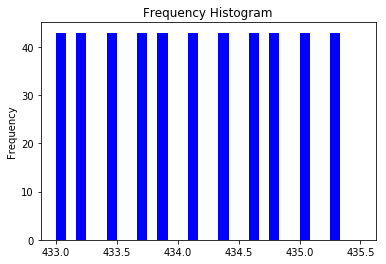

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.93%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =    434.14
std Freq =      0.72
length of inputs =  473


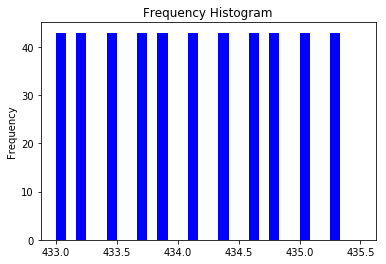

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.00%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [76]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_5msps.csv", histogram, delimiter=",")
c = 4
final_data_5msps[c,:] = pick(c,histogram)

inference file name =  ysf_5msps_test1.sigmf-meta
inference file name =  ysf_5msps_test10.sigmf-meta
inference file name =  ysf_5msps_test2.sigmf-meta
inference file name =  ysf_5msps_test3.sigmf-meta
inference file name =  ysf_5msps_test4.sigmf-meta
inference file name =  ysf_5msps_test5.sigmf-meta
inference file name =  ysf_5msps_test6.sigmf-meta
inference file name =  ysf_5msps_test7.sigmf-meta
inference file name =  ysf_5msps_test8.sigmf-meta
inference file name =  ysf_5msps_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


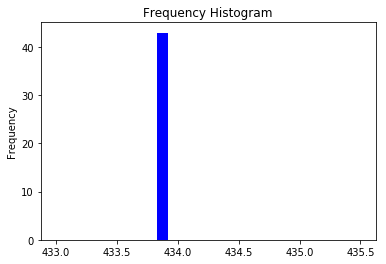

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.98%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


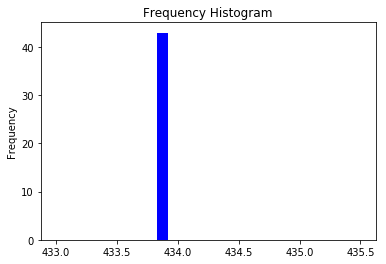

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


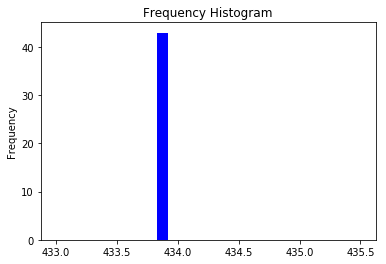

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


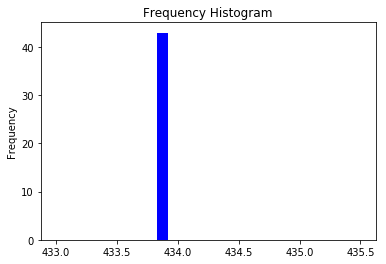

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.98%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


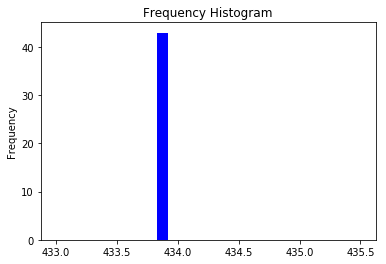

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


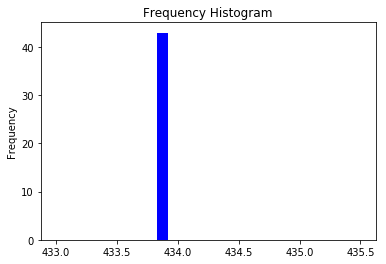

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


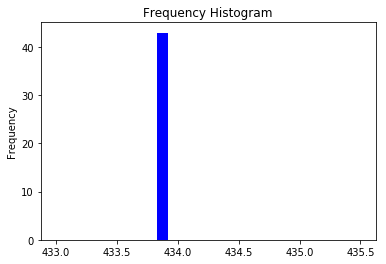

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


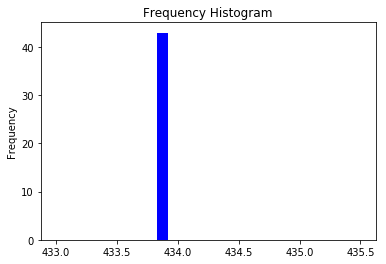

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


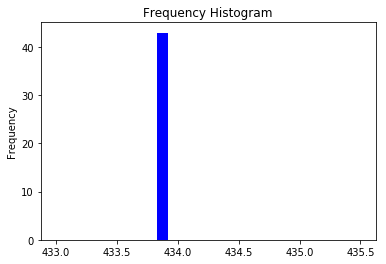

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([2541, 9766, 4])
start_frequency =  433.0
mean Freq =     39.45
std Freq =    124.74
length of inputs =  473


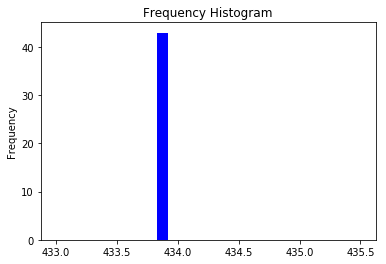

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0  0  0 10]


In [77]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_5msps.csv", histogram, delimiter=",")
c = 9
final_data_5msps[c,:] = pick(c,histogram)

In [78]:
final_data_5msps = final_data_5msps.astype(int)
final_data_5msps

array([[ 0,  0,  0,  0,  0,  3,  0,  7,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  5,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [79]:
np.trace(final_data_5msps)

46

In [80]:
os.chdir(path_confuse)
np.savetxt("ResNet50_20220210_1msps_train_score_5mspsdata_1classes.csv", final_data_5msps, delimiter=",")

#### 10msps

In [81]:
final_data_10msps = np.zeros((10,10))

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


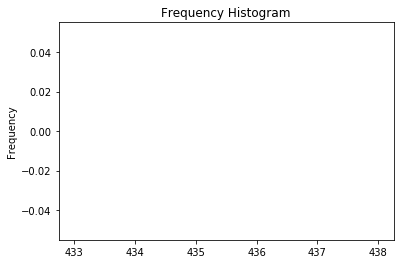

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


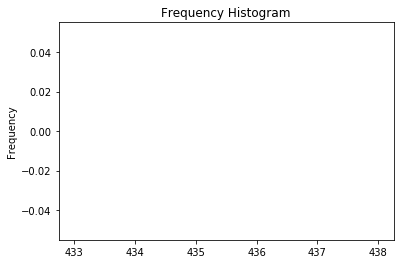

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


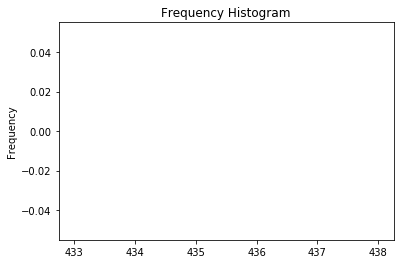

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


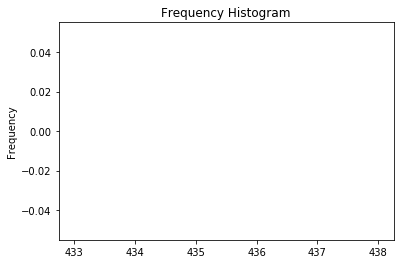

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


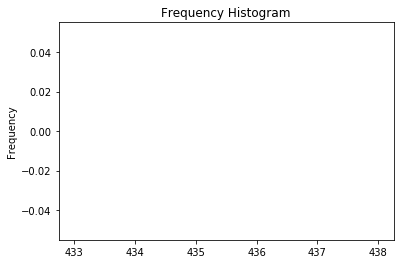

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


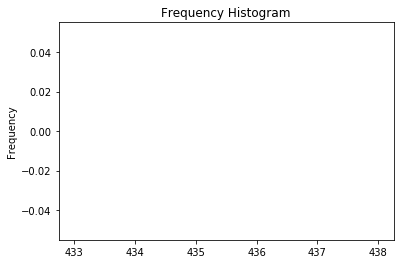

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


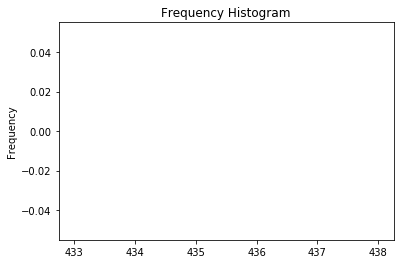

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


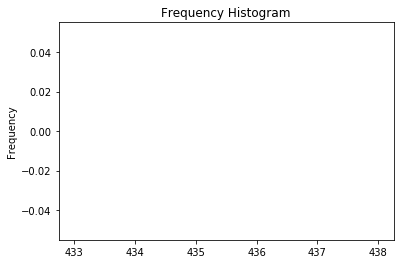

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


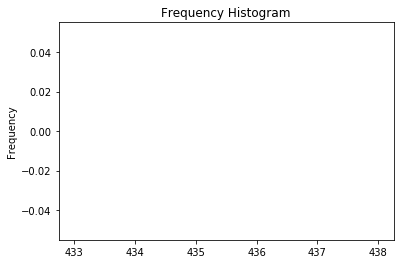

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


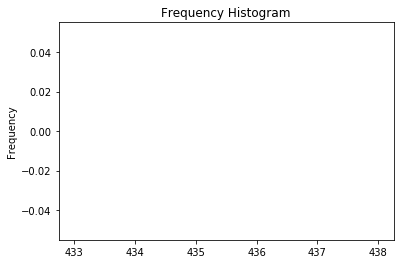

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************


In [82]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_10msps.csv", histogram, delimiter=",")

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


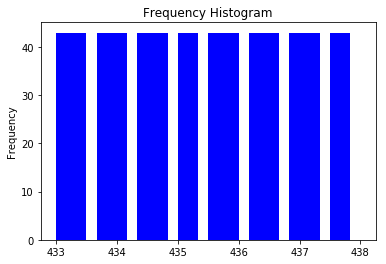

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


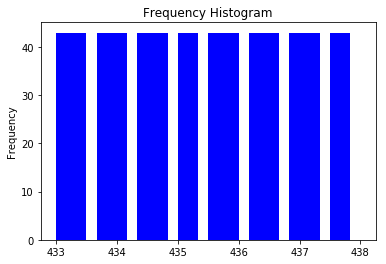

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


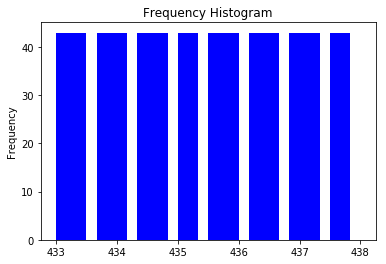

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.98%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


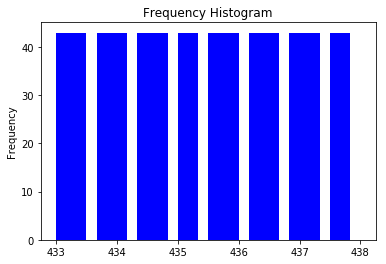

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


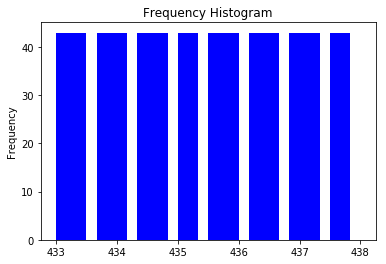

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


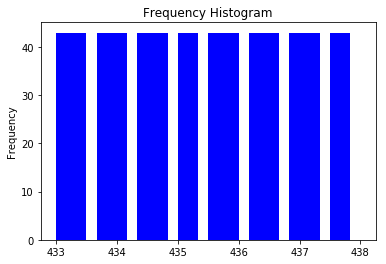

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.97%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


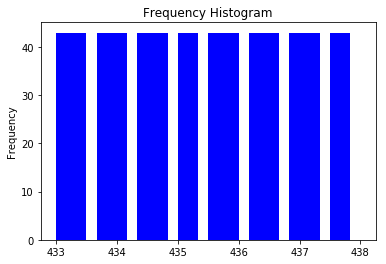

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


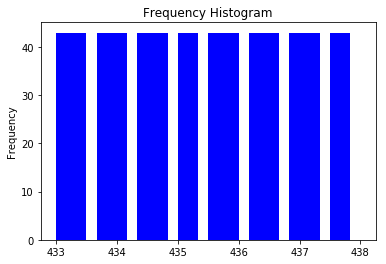

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.98%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


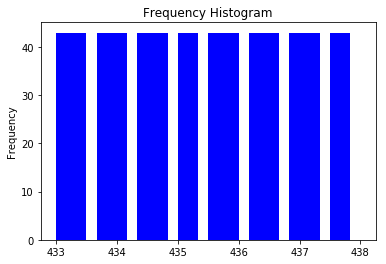

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


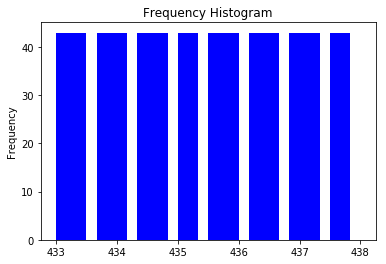

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]
Cycle time =  60.083125213044696


In [83]:
start = timer()
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_10msps.csv", histogram, delimiter=",")
c = 5
final_data_10msps[c,:] = pick(c,histogram)
end = timer()
total_time = end - start
print('Cycle time = ', total_time)

inference file name =  UHF_GD55_DMR_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    102.25
std Freq =    184.12
length of inputs =  946


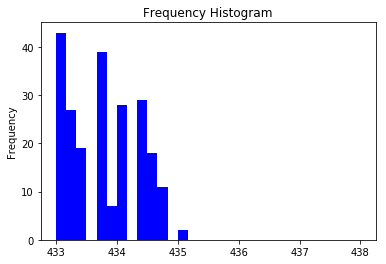

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.08%
Sado doorbell = 0.00%
LoRa 250 = 0.91%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  723
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


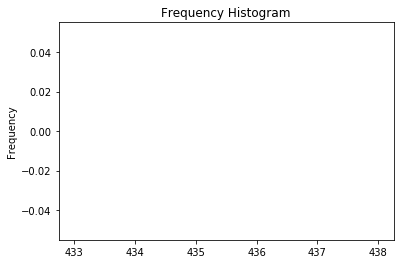

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


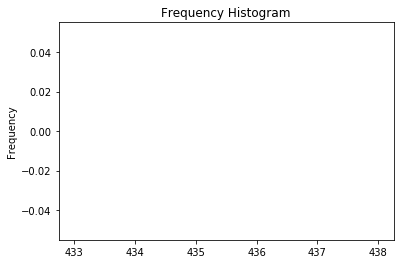

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


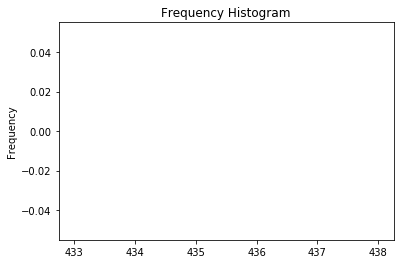

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


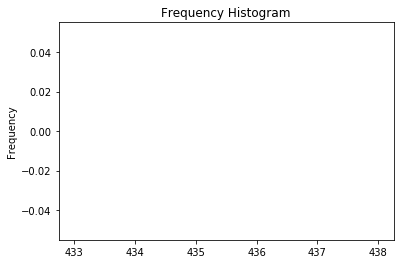

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


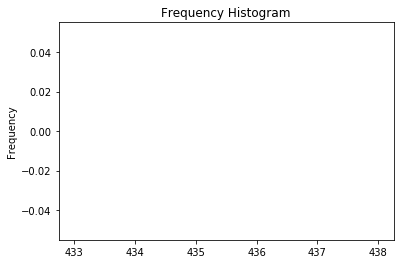

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.46
std Freq =     14.09
length of inputs =  946


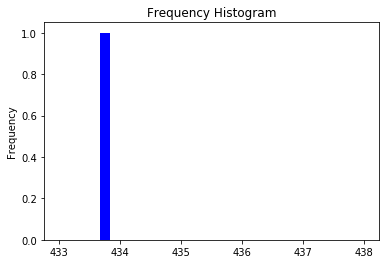

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  945
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


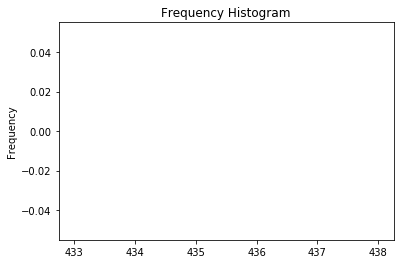

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


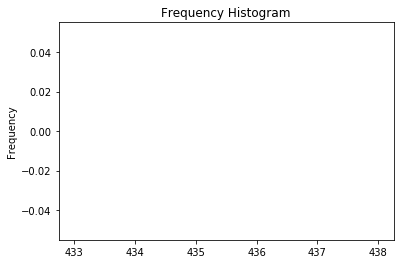

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =      0.00
std Freq =      0.00
length of inputs =  946


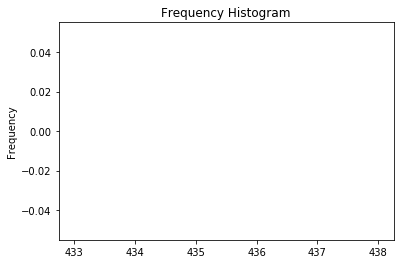

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
Nothing but noise
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  946
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 1 0 0 0 1 0 0]


In [84]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_10msps.csv", histogram, delimiter=",")
c = 1
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  sw1_50dBm_test1.sigmf-meta
inference file name =  sw1_50dBm_test2.sigmf-meta
inference file name =  sw1_50dBm_test3.sigmf-meta
inference file name =  sw1_50dBm_test4.sigmf-meta
inference file name =  sw1_50dBm_test5.sigmf-meta
inference file name =  sw1_60dBm_test10.sigmf-meta
inference file name =  sw1_60dBm_test6.sigmf-meta
inference file name =  sw1_60dBm_test7.sigmf-meta
inference file name =  sw1_60dBm_test8.sigmf-meta
inference file name =  sw1_60dBm_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


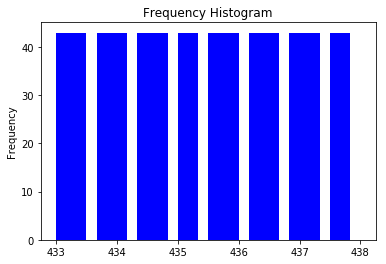

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.85%
LoRa 250 = 0.00%
light switch = 0.14%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


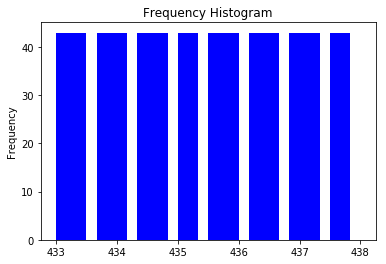

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.71%
LoRa 250 = 0.05%
light switch = 0.20%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


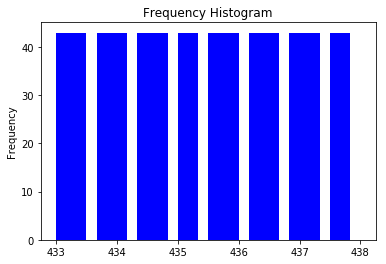

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.72%
LoRa 250 = 0.06%
light switch = 0.19%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


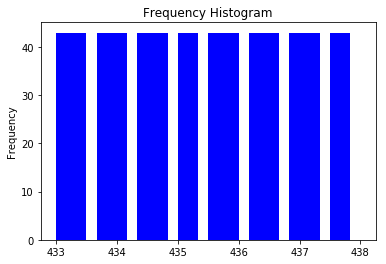

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.72%
LoRa 250 = 0.07%
light switch = 0.18%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


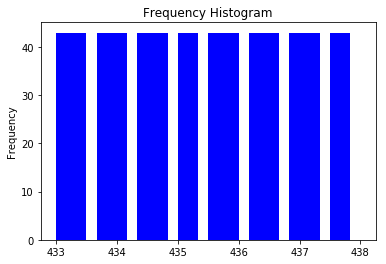

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.68%
LoRa 250 = 0.05%
light switch = 0.23%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     59.91
std Freq =    150.10
length of inputs =  946


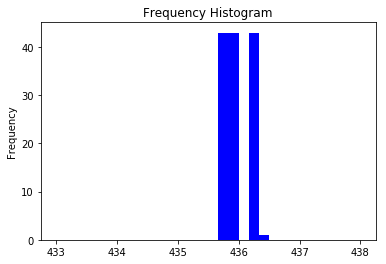

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.34%
LoRa 250 = 0.01%
light switch = 0.65%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  816
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     61.29
std Freq =    151.54
length of inputs =  946


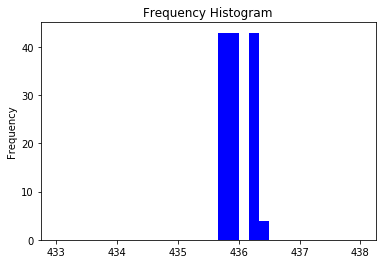

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.50%
LoRa 250 = 0.02%
light switch = 0.47%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  813
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     62.21
std Freq =    152.49
length of inputs =  946


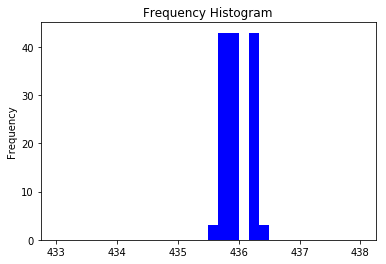

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.32%
LoRa 250 = 0.04%
light switch = 0.64%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  811
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     91.70
std Freq =    177.67
length of inputs =  946


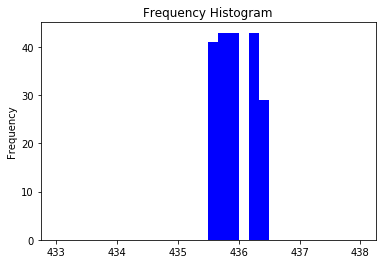

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.11%
Sado doorbell = 0.25%
LoRa 250 = 0.21%
light switch = 0.43%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  747
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     61.75
std Freq =    152.01
length of inputs =  946


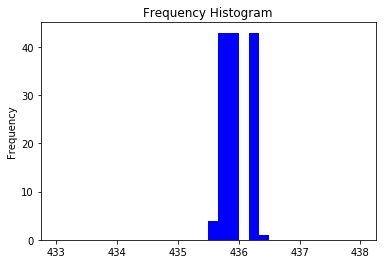

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.32%
LoRa 250 = 0.03%
light switch = 0.64%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  812
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 0 0 6 0 4 0]


In [85]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_10msps.csv", histogram, delimiter=",")
c = 8
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


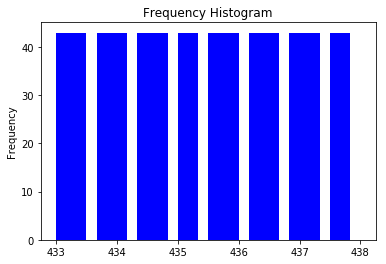

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


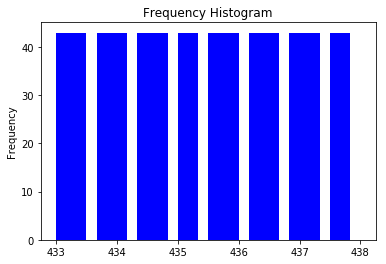

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


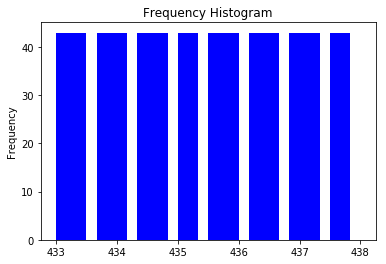

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


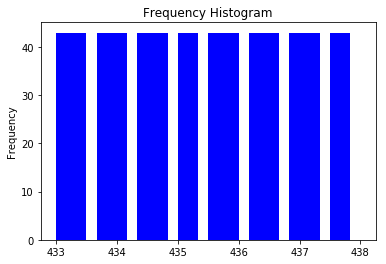

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


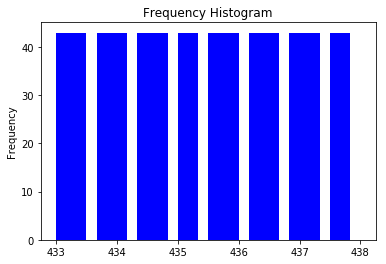

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


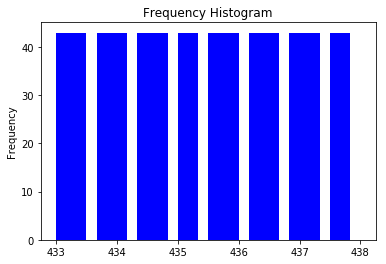

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


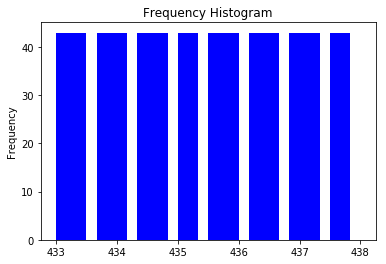

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


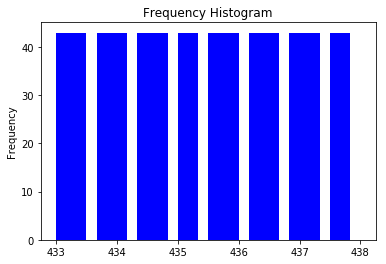

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.00%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


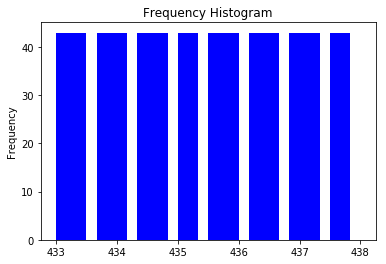

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


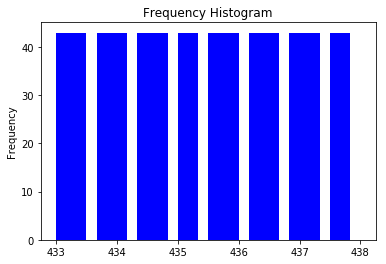

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.96%
LoRa 250 = 0.00%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [86]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_10msps.csv", histogram, delimiter=",")
c = 0
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    434.93
std Freq =     14.22
length of inputs =  946


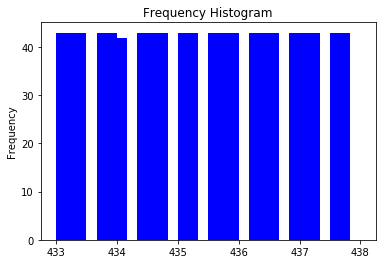

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


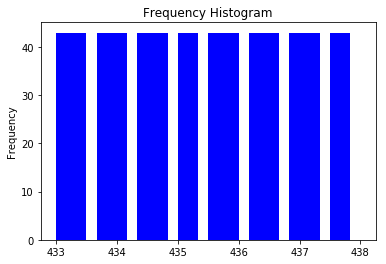

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


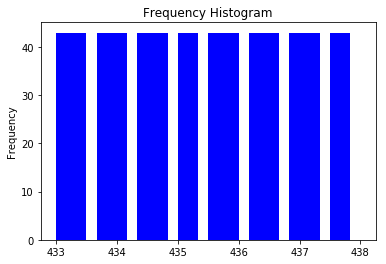

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


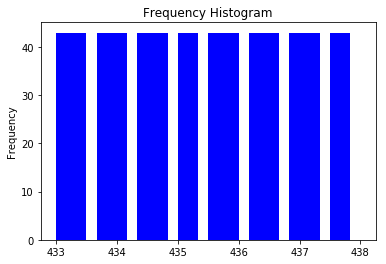

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    434.93
std Freq =     14.22
length of inputs =  946


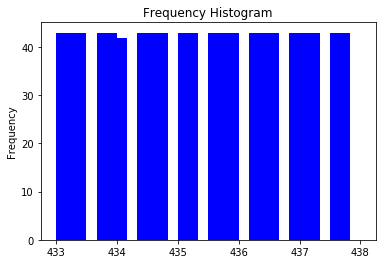

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    433.55
std Freq =     28.29
length of inputs =  946


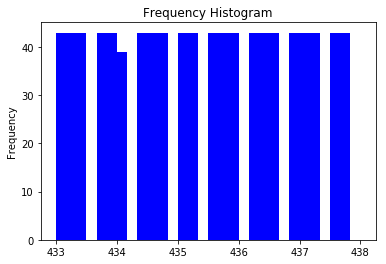

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.06%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  4
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


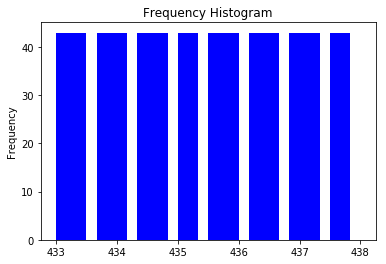

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    434.93
std Freq =     14.22
length of inputs =  946


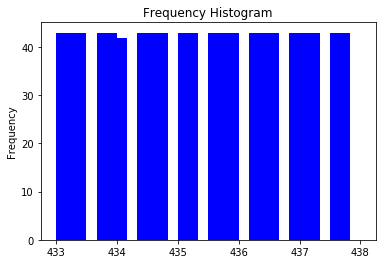

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    434.93
std Freq =     14.22
length of inputs =  946


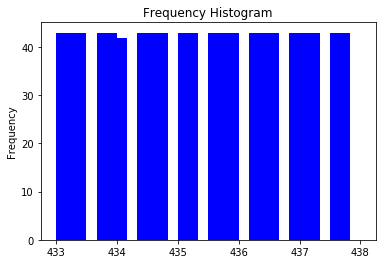

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.94%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  1
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


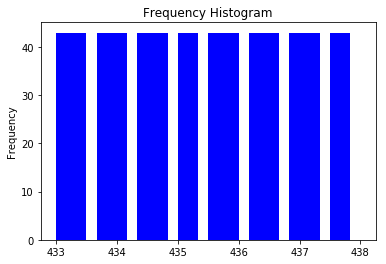

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.95%
LoRa 250 = 0.05%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [87]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_10msps.csv", histogram, delimiter=",")
c = 7
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_UV5R_voice_test1.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test10.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test2.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test3.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test4.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test5.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test6.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test7.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test8.sigmf-meta
inference file name =  UHF_NFM_UV5R_voice_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.80
std Freq =     90.71
length of inputs =  946


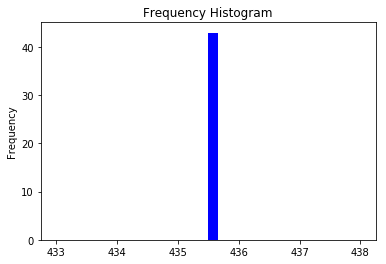

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.36
std Freq =     89.80
length of inputs =  946


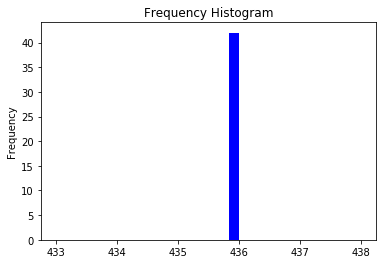

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.98%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  904
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


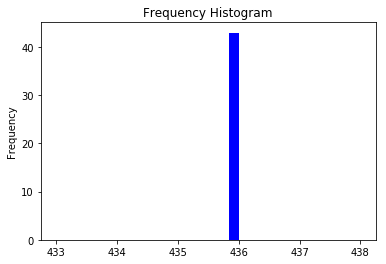

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.09%
NFM = 0.91%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


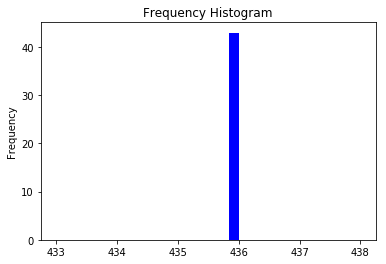

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


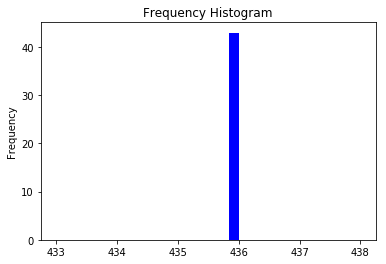

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     20.28
std Freq =     91.81
length of inputs =  946


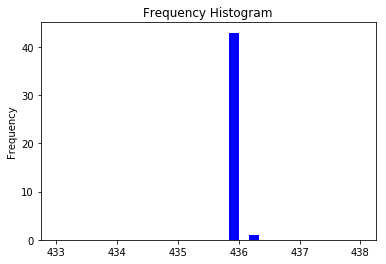

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.98%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  902
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


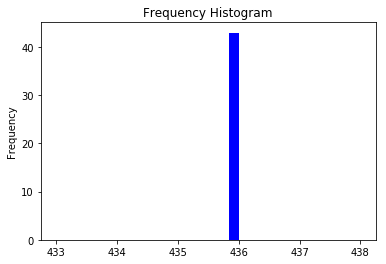

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


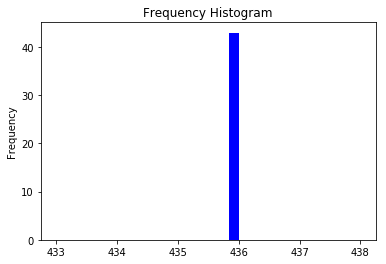

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     17.97
std Freq =     86.67
length of inputs =  946


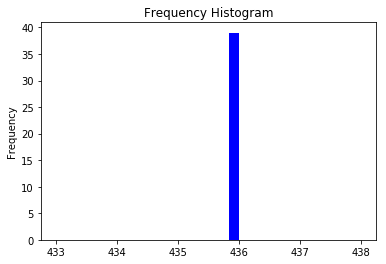

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.97%
TYT = 0.03
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  907
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.82
std Freq =     90.81
length of inputs =  946


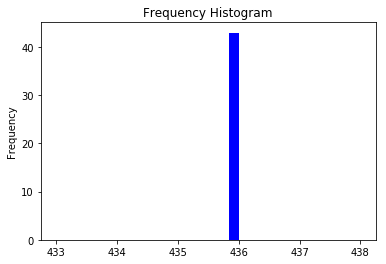

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 1.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0 10  0  0  0  0  0  0  0]


In [88]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_uv5r)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_10msps.csv", histogram, delimiter=",")
c = 2
final_data_10msps[c,:] = pick(c,histogram)

In [89]:
# msps = 10
# center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_vx8)
# histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()
# os.chdir(path_output4D)
# np.savetxt("nfm_10msps.csv", histogram, delimiter=",")
# c = 2
# final_data_10msps[c,:] = pick(c,histogram)

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


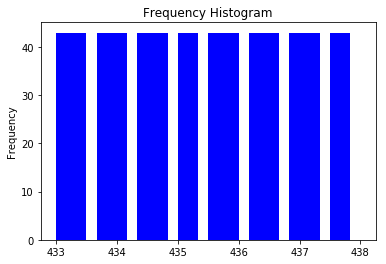

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


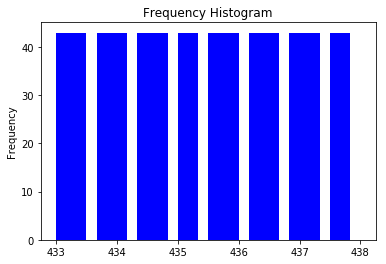

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


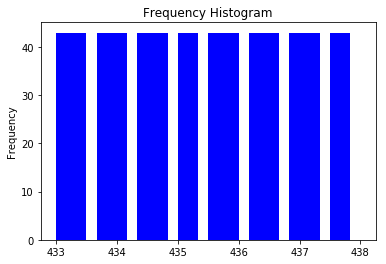

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


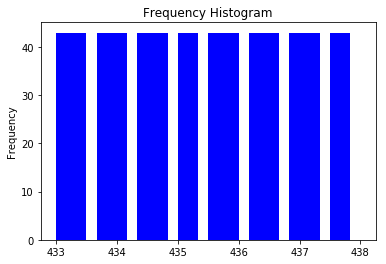

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


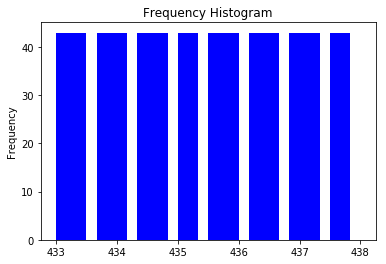

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


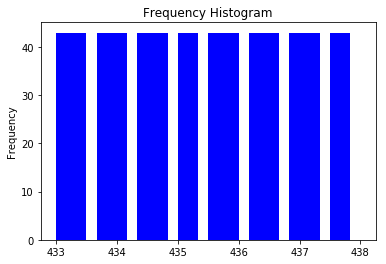

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


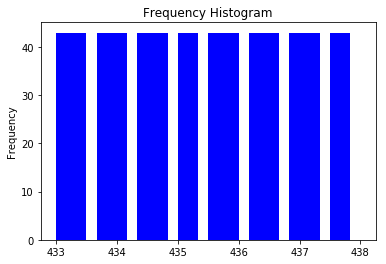

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


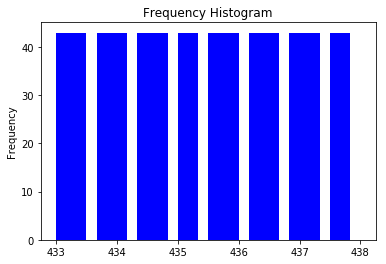

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


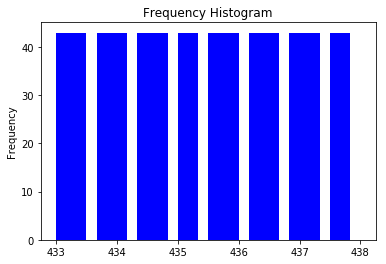

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


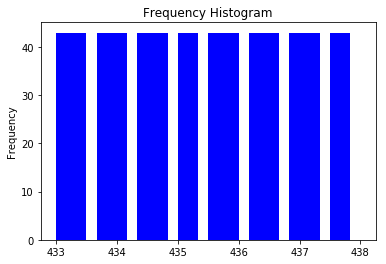

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [90]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_10msps.csv", histogram, delimiter=",")
c = 6
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     18.81
std Freq =     88.35
length of inputs =  946


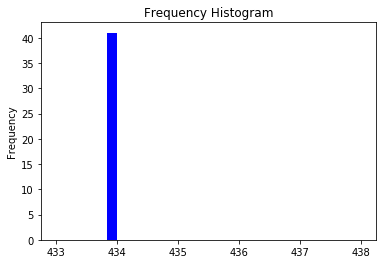

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  905
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     16.05
std Freq =     81.90
length of inputs =  946


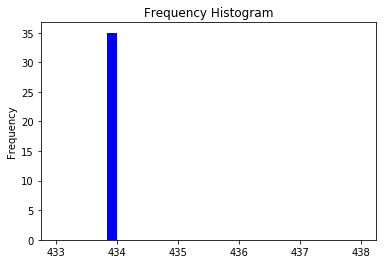

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  911
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     18.35
std Freq =     87.32
length of inputs =  946


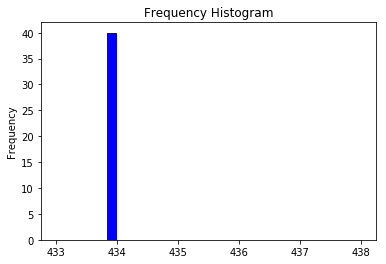

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  906
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     17.43
std Freq =     85.20
length of inputs =  946


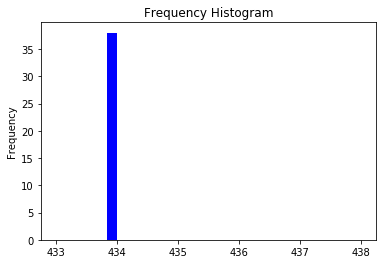

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  908
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.26
std Freq =     89.38
length of inputs =  946


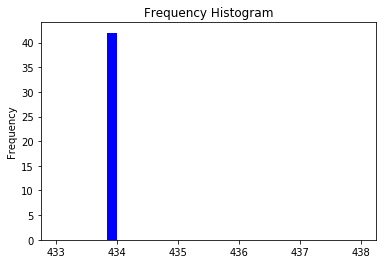

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  904
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     18.35
std Freq =     87.32
length of inputs =  946


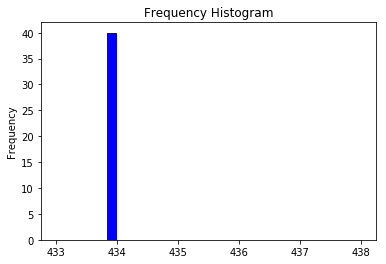

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  906
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     15.60
std Freq =     80.77
length of inputs =  946


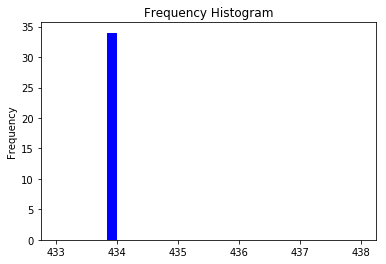

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  912
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     18.81
std Freq =     88.35
length of inputs =  946


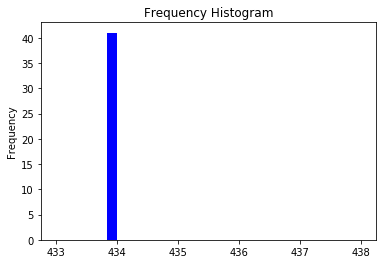

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  905
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.26
std Freq =     89.38
length of inputs =  946


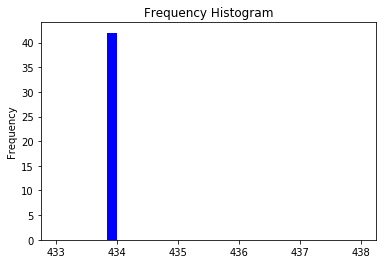

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  904
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     18.81
std Freq =     88.35
length of inputs =  946


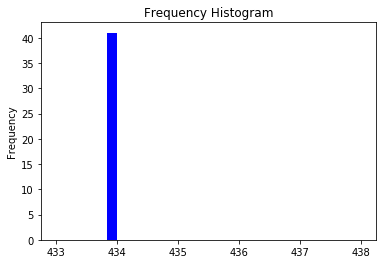

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 1.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  905
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0 10  0  0  0  0  0  0]


In [91]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_10msps.csv", histogram, delimiter=",")
c = 3
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


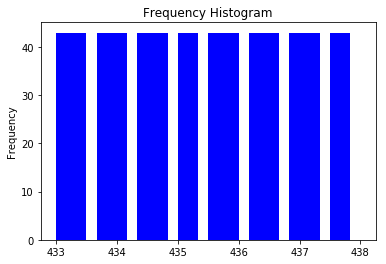

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


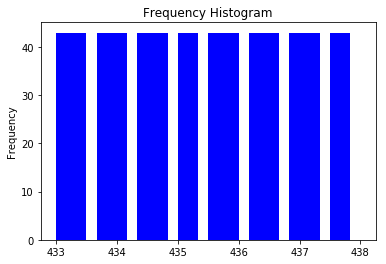

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


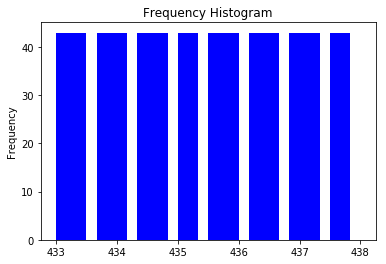

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


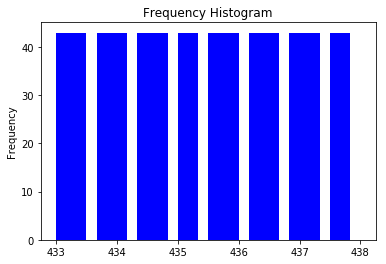

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


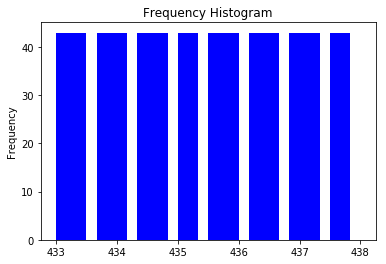

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 1.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


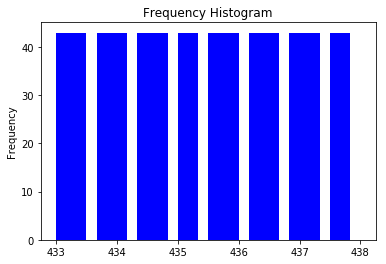

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


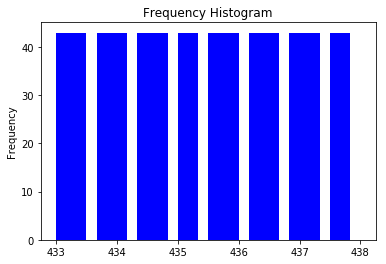

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


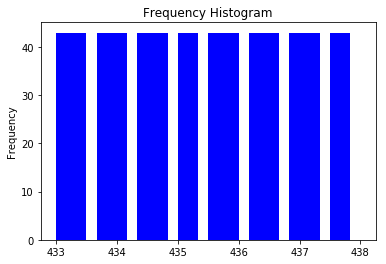

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


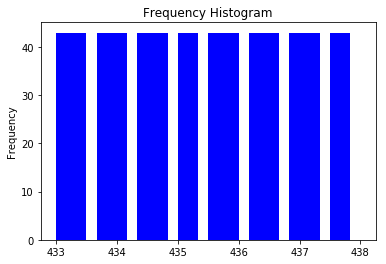

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =    435.39
std Freq =      1.44
length of inputs =  946


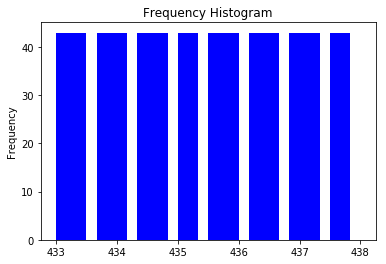

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.99%
LoRa 250 = 0.00%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [92]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_10msps.csv", histogram, delimiter=",")
c = 4
final_data_10msps[c,:] = pick(c,histogram)

inference file name =  ysf_10msps_test1.sigmf-meta
inference file name =  ysf_10msps_test10.sigmf-meta
inference file name =  ysf_10msps_test2.sigmf-meta
inference file name =  ysf_10msps_test3.sigmf-meta
inference file name =  ysf_10msps_test4.sigmf-meta
inference file name =  ysf_10msps_test5.sigmf-meta
inference file name =  ysf_10msps_test6.sigmf-meta
inference file name =  ysf_10msps_test7.sigmf-meta
inference file name =  ysf_10msps_test8.sigmf-meta
inference file name =  ysf_10msps_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


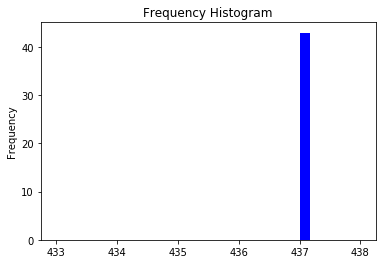

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


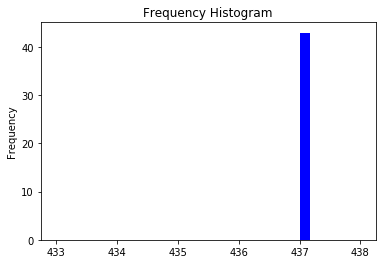

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


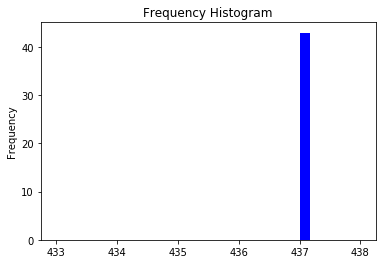

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


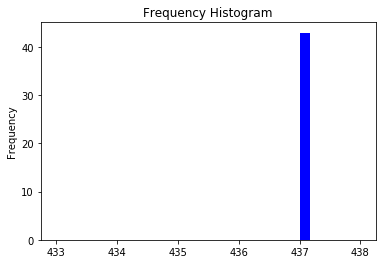

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


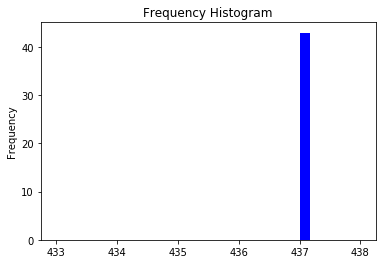

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


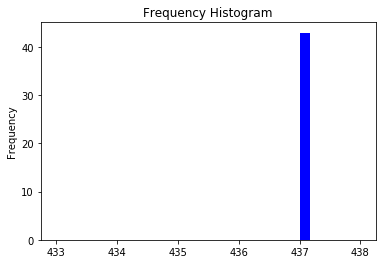

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


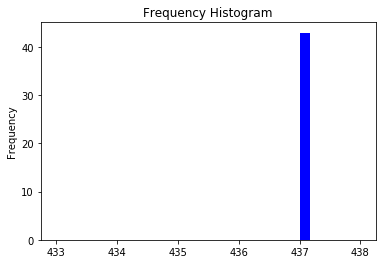

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


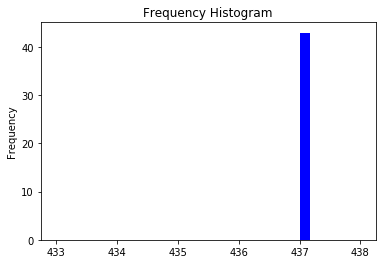

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


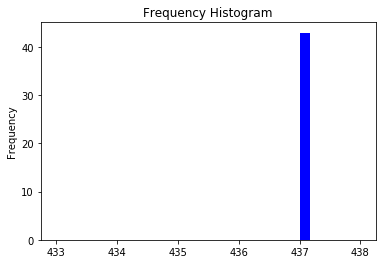

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([5101, 9766, 4])
start_frequency =  433.0
mean Freq =     19.87
std Freq =     91.05
length of inputs =  946


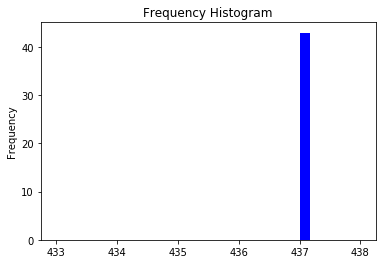

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 1.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  903
center fft matches =  0
TOTAL patch count =  946
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0  0  0  0 10]


In [93]:
msps = 10
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_10msps.csv", histogram, delimiter=",")
c = 9
final_data_10msps[c,:] = pick(c,histogram)

In [94]:
final_data_10msps = final_data_10msps.astype(int)
final_data_10msps

array([[ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  0,  4,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10]])

In [95]:
np.trace(final_data_10msps)

44

In [96]:
os.chdir(path_confuse)
np.savetxt("ResNet50_20220210_1msps_train_score_10mspsdata_1classes.csv", final_data_10msps, delimiter=",")

#### 25msps scoring

In [102]:
final_data_25msps = np.zeros((10,10))

In [103]:
choice = 2

inference file name =  noise_test1.sigmf-meta
inference file name =  noise_test10.sigmf-meta
inference file name =  noise_test2.sigmf-meta
inference file name =  noise_test3.sigmf-meta
inference file name =  noise_test4.sigmf-meta
inference file name =  noise_test5.sigmf-meta
inference file name =  noise_test6.sigmf-meta
inference file name =  noise_test7.sigmf-meta
inference file name =  noise_test8.sigmf-meta
inference file name =  noise_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    315.82
std Freq =    194.52
length of inputs =  2451


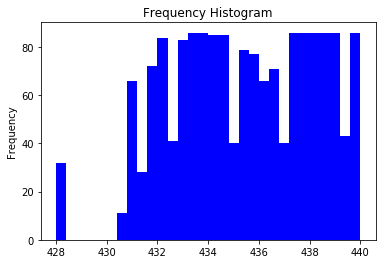

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.10%
LoRa 250 = 0.84%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  674
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    315.64
std Freq =    194.61
length of inputs =  2451


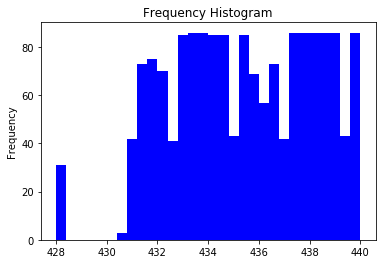

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.12%
LoRa 250 = 0.83%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  675
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    318.13
std Freq =    193.34
length of inputs =  2451


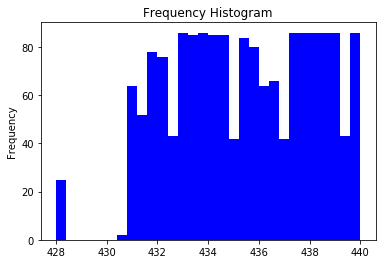

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.11%
LoRa 250 = 0.85%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  661
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    286.36
std Freq =    206.79
length of inputs =  2451


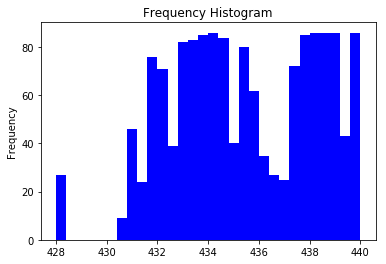

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.07%
LoRa 250 = 0.87%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  840
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    302.52
std Freq =    200.70
length of inputs =  2451


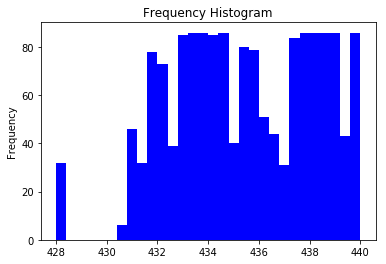

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.09%
LoRa 250 = 0.86%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  749
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    307.97
std Freq =    198.25
length of inputs =  2451


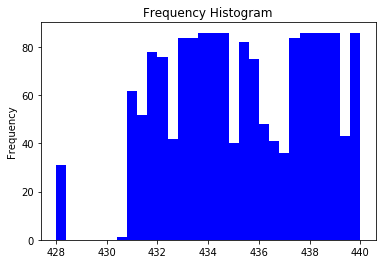

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.09%
LoRa 250 = 0.86%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  718
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    303.65
std Freq =    200.29
length of inputs =  2451


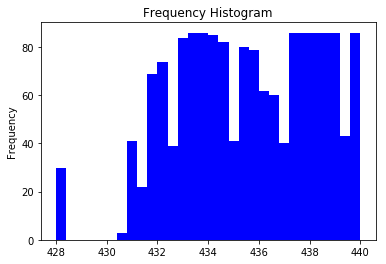

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.11%
LoRa 250 = 0.84%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  743
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    288.52
std Freq =    206.09
length of inputs =  2451


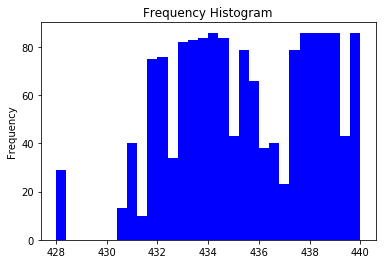

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.09%
LoRa 250 = 0.86%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  828
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    298.19
std Freq =    202.59
length of inputs =  2451


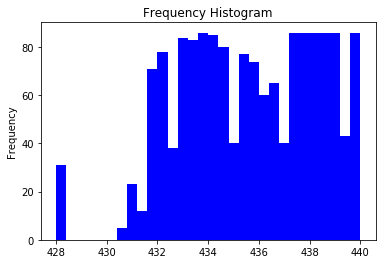

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.05%
Sado doorbell = 0.10%
LoRa 250 = 0.84%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  774
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    284.89
std Freq =    207.23
length of inputs =  2451


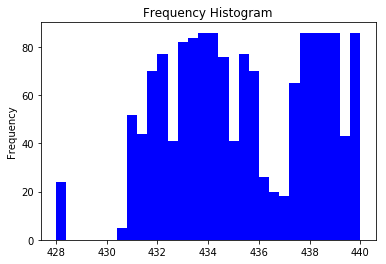

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.06%
LoRa 250 = 0.88%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  848
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [104]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_noise)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_noise)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("noise_25msps.csv", histogram, delimiter=",")

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
inference file name =  UHF_clickndig_fob1_test10.sigmf-meta
inference file name =  UHF_clickndig_fob1_test2.sigmf-meta
inference file name =  UHF_clickndig_fob1_test3.sigmf-meta
inference file name =  UHF_clickndig_fob1_test4.sigmf-meta
inference file name =  UHF_clickndig_fob1_test5.sigmf-meta
inference file name =  UHF_clickndig_fob1_test6.sigmf-meta
inference file name =  UHF_clickndig_fob1_test7.sigmf-meta
inference file name =  UHF_clickndig_fob1_test8.sigmf-meta
inference file name =  UHF_clickndig_fob1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


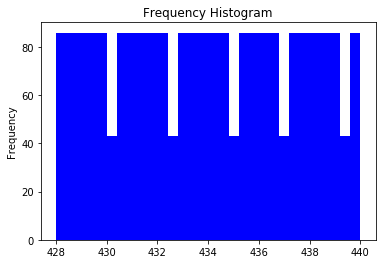

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


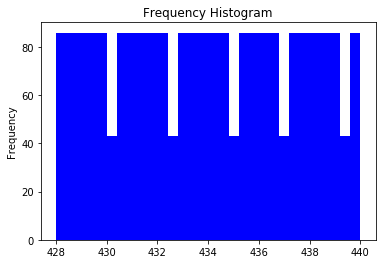

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


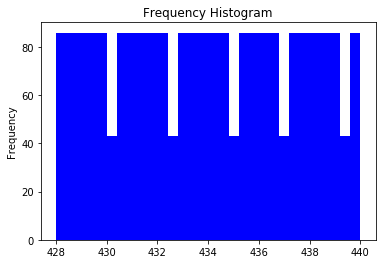

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


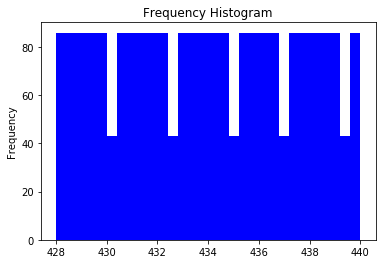

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.92%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


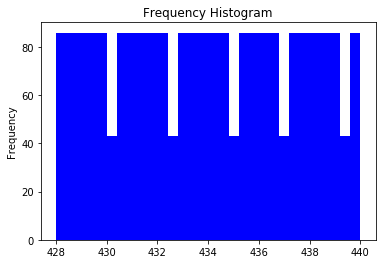

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.92%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


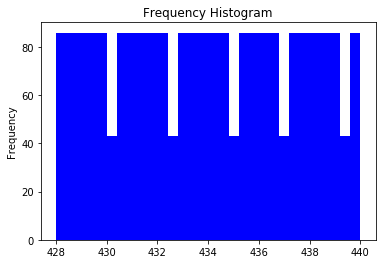

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.92%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


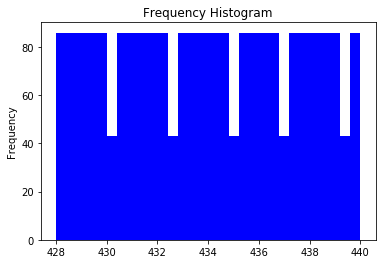

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.92%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


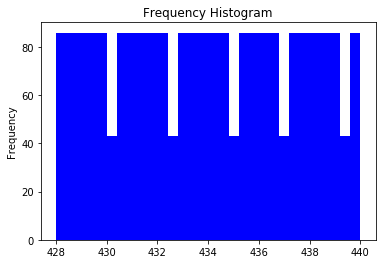

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


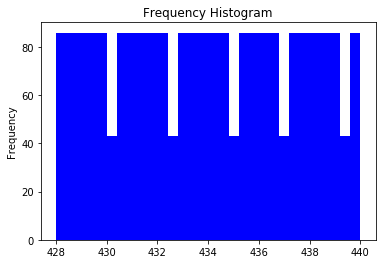

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


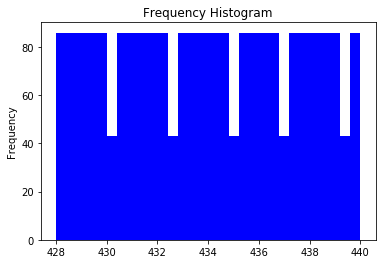

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]
Cycle time =  153.74275394901633


In [105]:
start = timer()
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_click)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_click)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("click_25msps.csv", histogram, delimiter=",")
c = 5
final_data_25msps[c,:] = pick(c,histogram)
end = timer()
total_time = end - start
print('Cycle time = ', total_time)

inference file name =  UHF_GD55_DMR_test1.sigmf-meta
inference file name =  UHF_GD55_DMR_test10.sigmf-meta
inference file name =  UHF_GD55_DMR_test2.sigmf-meta
inference file name =  UHF_GD55_DMR_test3.sigmf-meta
inference file name =  UHF_GD55_DMR_test4.sigmf-meta
inference file name =  UHF_GD55_DMR_test5.sigmf-meta
inference file name =  UHF_GD55_DMR_test6.sigmf-meta
inference file name =  UHF_GD55_DMR_test7.sigmf-meta
inference file name =  UHF_GD55_DMR_test8.sigmf-meta
inference file name =  UHF_GD55_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


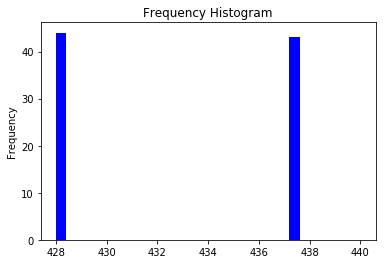

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


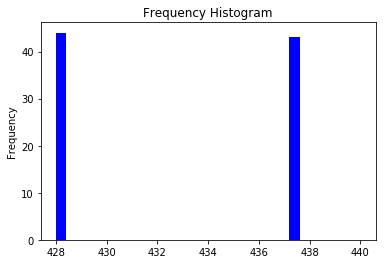

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.02%
NFM = 0.47%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


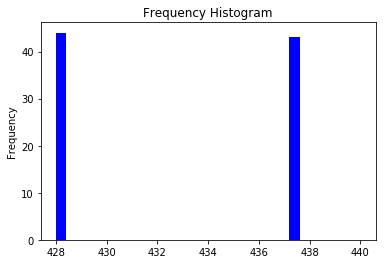

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.16%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


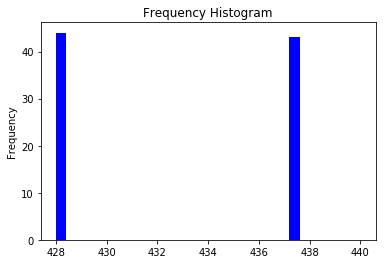

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.08%
NFM = 0.41%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


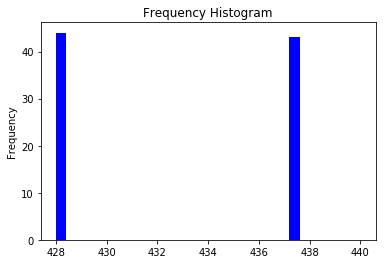

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.07%
NFM = 0.43%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


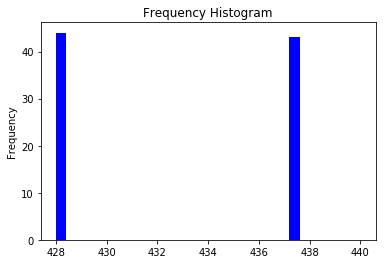

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.18%
NFM = 0.31%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


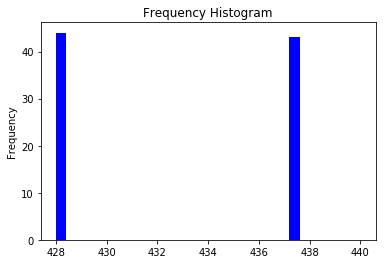

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.03%
NFM = 0.46%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


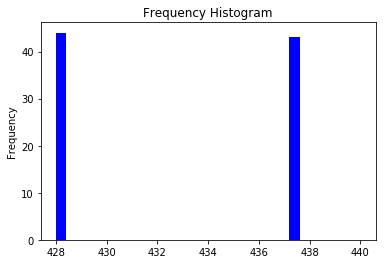

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.03%
NFM = 0.46%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


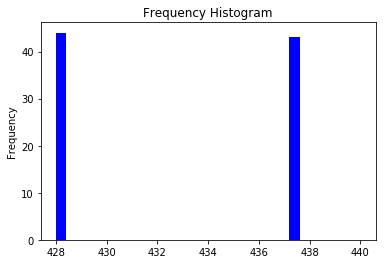

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


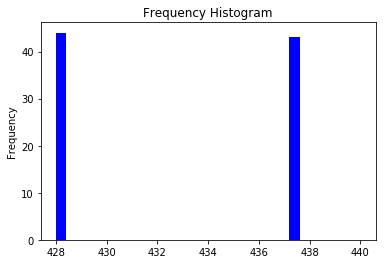

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 3 0 0 0 7 0 0 0]


In [106]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_gd55)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_gd55)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("gd55_25msps.csv", histogram, delimiter=",")
c = 1
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  sw1_910_test1.sigmf-meta
inference file name =  sw1_910_test10.sigmf-meta
inference file name =  sw1_910_test2.sigmf-meta
inference file name =  sw1_910_test3.sigmf-meta
inference file name =  sw1_910_test4.sigmf-meta
inference file name =  sw1_910_test5.sigmf-meta
inference file name =  sw1_910_test6.sigmf-meta
inference file name =  sw1_910_test7.sigmf-meta
inference file name =  sw1_910_test8.sigmf-meta
inference file name =  sw1_910_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    398.78
std Freq =    117.94
length of inputs =  2451


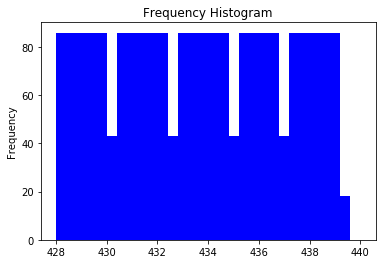

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.27%
Sado doorbell = 0.58%
LoRa 250 = 0.12%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  197
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    398.78
std Freq =    117.94
length of inputs =  2451


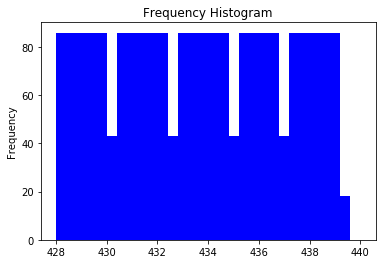

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.29%
Sado doorbell = 0.60%
LoRa 250 = 0.11%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  197
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    400.04
std Freq =    116.01
length of inputs =  2451


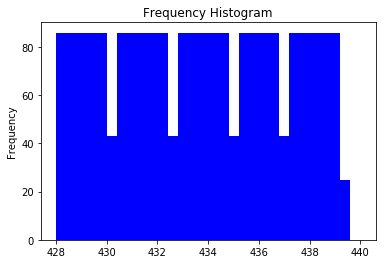

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.20%
Sado doorbell = 0.61%
LoRa 250 = 0.12%
light switch = 0.08%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  190
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    401.29
std Freq =    114.04
length of inputs =  2451


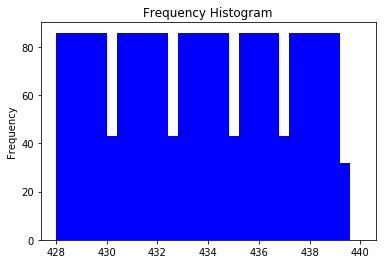

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.08%
Sado doorbell = 0.69%
LoRa 250 = 0.11%
light switch = 0.11%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  183
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    398.78
std Freq =    117.94
length of inputs =  2451


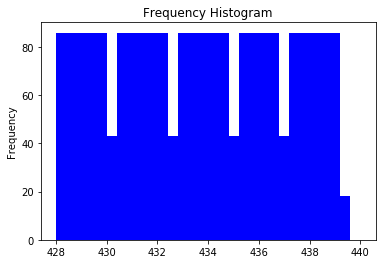

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.24%
Sado doorbell = 0.60%
LoRa 250 = 0.12%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  197
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    399.14
std Freq =    117.39
length of inputs =  2451


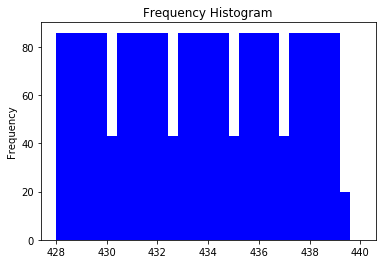

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.31%
Sado doorbell = 0.57%
LoRa 250 = 0.12%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  195
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    398.78
std Freq =    117.94
length of inputs =  2451


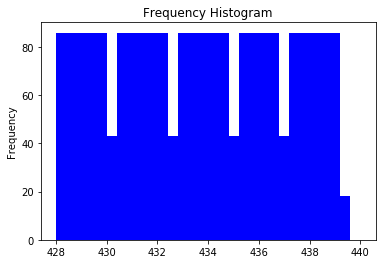

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.17%
Sado doorbell = 0.63%
LoRa 250 = 0.12%
light switch = 0.08%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  197
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    401.83
std Freq =    113.17
length of inputs =  2451


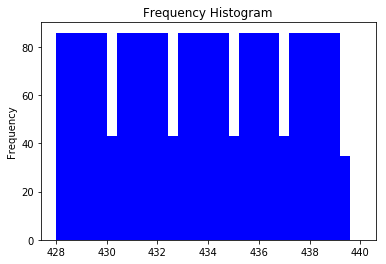

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.67%
LoRa 250 = 0.12%
light switch = 0.13%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  180
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    398.96
std Freq =    117.67
length of inputs =  2451


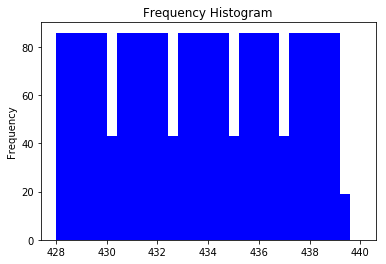

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.33%
Sado doorbell = 0.56%
LoRa 250 = 0.11%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  196
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    399.32
std Freq =    117.12
length of inputs =  2451


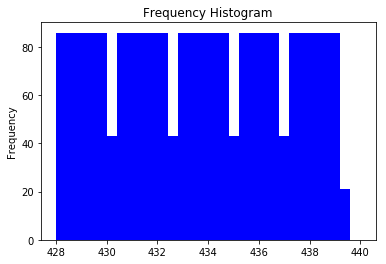

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.27%
Sado doorbell = 0.58%
LoRa 250 = 0.11%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  194
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [107]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_light)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_light)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("light_25msps.csv", histogram, delimiter=",")
c = 8
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  lora125_test1.sigmf-meta
inference file name =  lora125_test10.sigmf-meta
inference file name =  lora125_test2.sigmf-meta
inference file name =  lora125_test3.sigmf-meta
inference file name =  lora125_test4.sigmf-meta
inference file name =  lora125_test5.sigmf-meta
inference file name =  lora125_test6.sigmf-meta
inference file name =  lora125_test7.sigmf-meta
inference file name =  lora125_test8.sigmf-meta
inference file name =  lora125_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


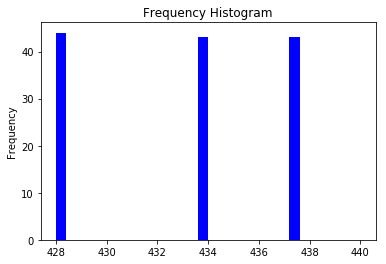

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     25.62
std Freq =    102.18
length of inputs =  2451


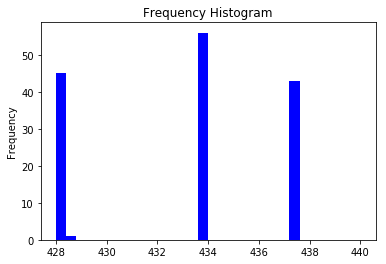

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.30%
GD55 DMR = 0.01%
NFM = 0.29%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.09%
Sado doorbell = 0.31%
LoRa 250 = 0.01%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2306
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


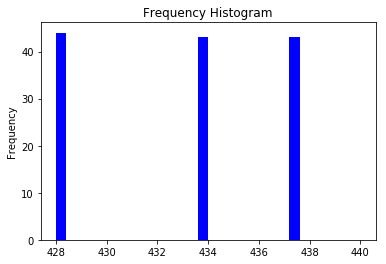

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.20%
TYT = 0.00
Vodeson Doorbell = 0.13%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.86
std Freq =     98.81
length of inputs =  2451


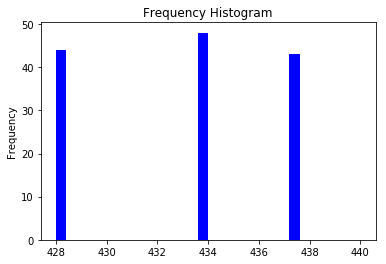

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.32%
GD55 DMR = 0.00%
NFM = 0.32%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.32%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2316
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


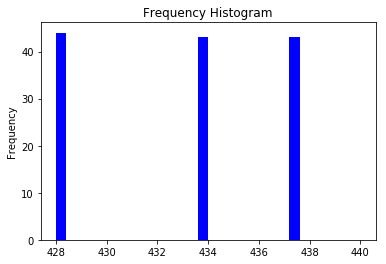

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.33%
GD55 DMR = 0.00%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


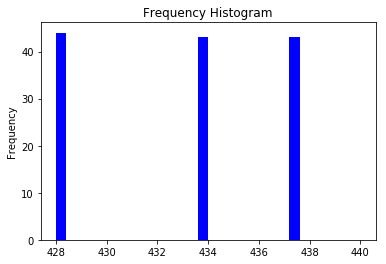

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.26%
TYT = 0.00
Vodeson Doorbell = 0.07%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.33%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


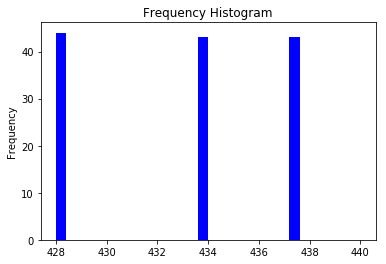

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.30%
GD55 DMR = 0.00%
NFM = 0.32%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


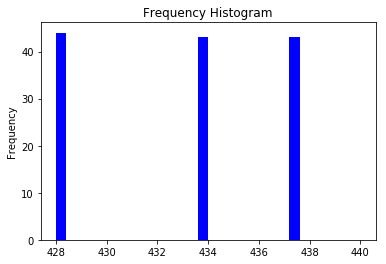

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.33%
GD55 DMR = 0.00%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.97
std Freq =     97.06
length of inputs =  2451


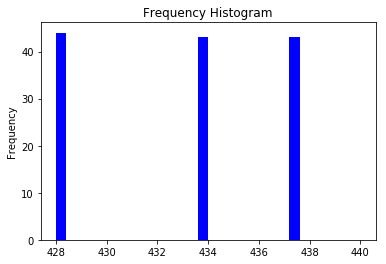

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.33%
GD55 DMR = 0.00%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.86
std Freq =     98.81
length of inputs =  2451


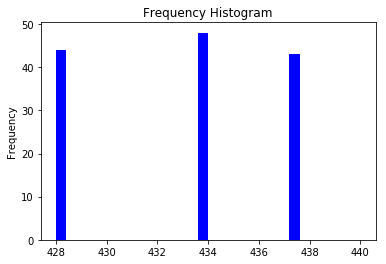

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.32%
GD55 DMR = 0.00%
NFM = 0.32%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.32%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2316
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [5 0 1 0 0 0 4 0 0 0]


In [108]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_lora125)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora125)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora125_25msps.csv", histogram, delimiter=",")
c = 0
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  lora250_test1.sigmf-meta
inference file name =  lora250_test10.sigmf-meta
inference file name =  lora250_test2.sigmf-meta
inference file name =  lora250_test3.sigmf-meta
inference file name =  lora250_test4.sigmf-meta
inference file name =  lora250_test5.sigmf-meta
inference file name =  lora250_test6.sigmf-meta
inference file name =  lora250_test7.sigmf-meta
inference file name =  lora250_test8.sigmf-meta
inference file name =  lora250_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     27.22
std Freq =    105.12
length of inputs =  2451


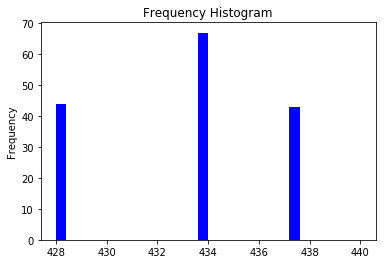

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.28%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.27%
Sado doorbell = 0.32%
LoRa 250 = 0.08%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2297
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     29.34
std Freq =    108.86
length of inputs =  2451


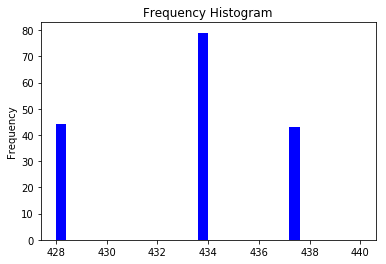

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.26%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.26%
LoRa 250 = 0.45%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2285
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     26.33
std Freq =    103.51
length of inputs =  2451


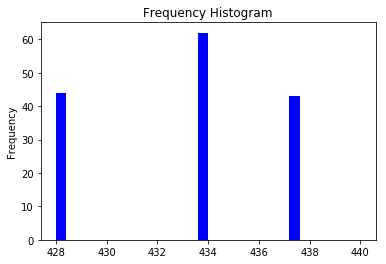

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.28%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.26%
Sado doorbell = 0.38%
LoRa 250 = 0.05%
light switch = 0.02%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2302
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     27.57
std Freq =    105.75
length of inputs =  2451


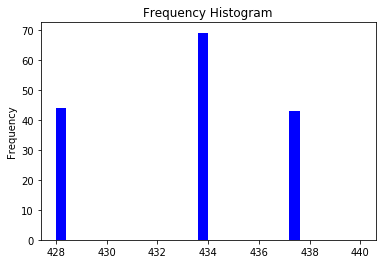

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.21%
TYT = 0.00
Vodeson Doorbell = 0.06%
clickndig = 0.32%
Sado doorbell = 0.38%
LoRa 250 = 0.01%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2295
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     26.86
std Freq =    104.48
length of inputs =  2451


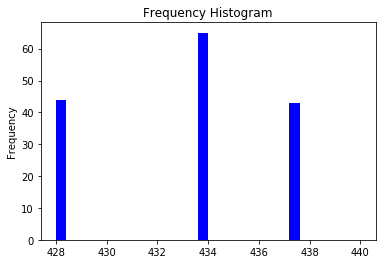

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.28%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.25%
Sado doorbell = 0.31%
LoRa 250 = 0.15%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2299
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     30.23
std Freq =    110.37
length of inputs =  2451


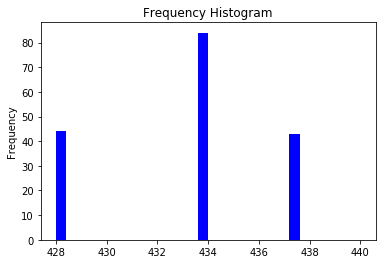

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.25%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.25%
LoRa 250 = 0.47%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2280
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     27.39
std Freq =    105.44
length of inputs =  2451


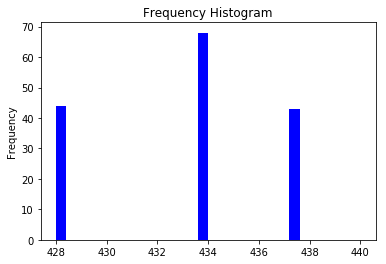

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.25%
TYT = 0.00
Vodeson Doorbell = 0.03%
clickndig = 0.21%
Sado doorbell = 0.33%
LoRa 250 = 0.17%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2296
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     30.05
std Freq =    110.07
length of inputs =  2451


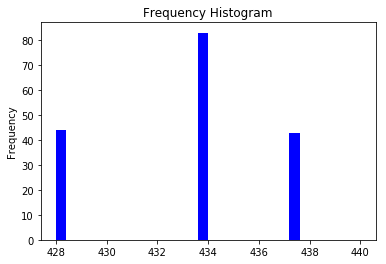

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.25%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.25%
LoRa 250 = 0.48%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2281
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     29.16
std Freq =    108.56
length of inputs =  2451


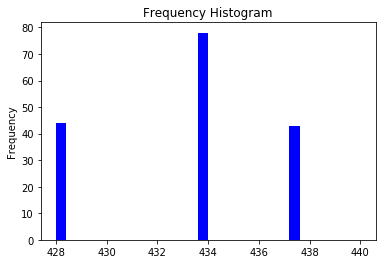

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.26%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.06%
Sado doorbell = 0.26%
LoRa 250 = 0.42%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2286
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     29.34
std Freq =    108.86
length of inputs =  2451


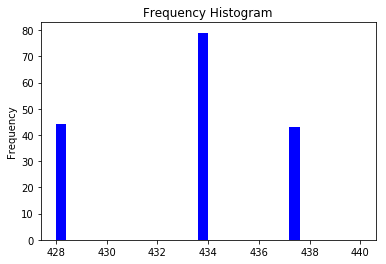

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.25%
TYT = 0.00
Vodeson Doorbell = 0.01%
clickndig = 0.10%
Sado doorbell = 0.30%
LoRa 250 = 0.34%
light switch = 0.01%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2285
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 0 0 5 5 0 0]


In [109]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_lora250)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_lora250)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("lora250_25msps.csv", histogram, delimiter=",")
c = 7
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  UHF_NFM_VX8_voice_test1.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test10.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test2.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test3.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test4.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test5.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test6.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test7.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test8.sigmf-meta
inference file name =  UHF_NFM_VX8_voice_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.12
std Freq =     95.41
length of inputs =  2451


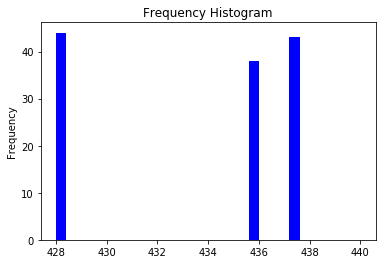

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.30%
NFM = 0.34%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.34%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2326
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


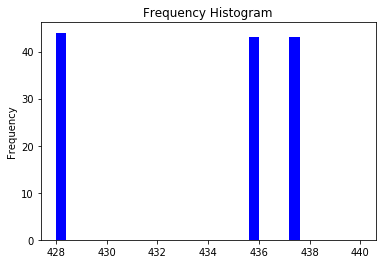

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.33%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.12
std Freq =     95.41
length of inputs =  2451


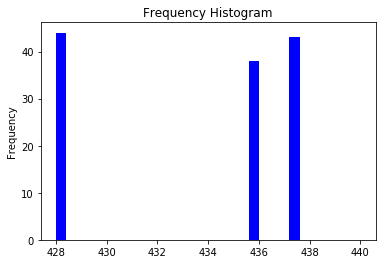

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.29%
NFM = 0.34%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.34%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2326
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


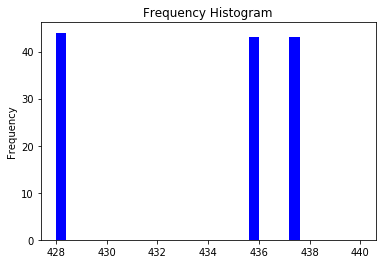

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.26%
NFM = 0.38%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


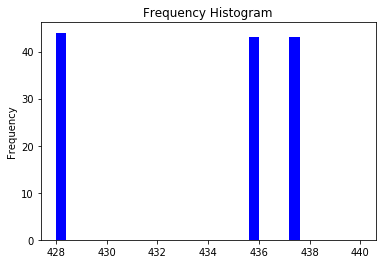

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.31%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.02%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


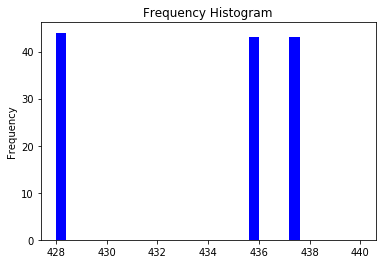

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.33%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


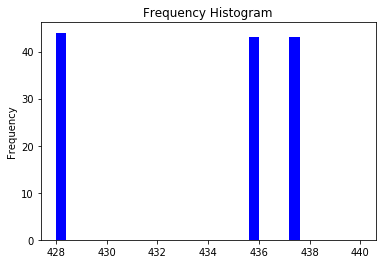

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.33%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     22.12
std Freq =     95.41
length of inputs =  2451


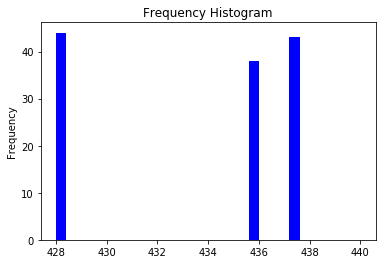

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.30%
NFM = 0.34%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.34%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.01%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2326
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     21.40
std Freq =     93.93
length of inputs =  2451


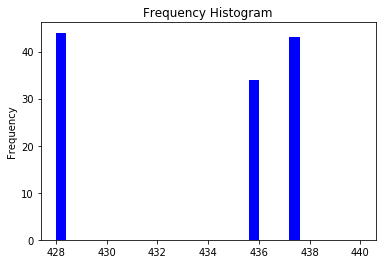

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.24%
NFM = 0.36%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.36%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.04%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2330
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     23.00
std Freq =     97.21
length of inputs =  2451


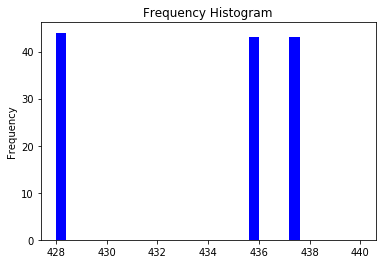

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.33%
NFM = 0.33%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.33%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2321
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  4 10  0  0  0  0  0  0  0]


In [110]:
# choice = 2
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_uv5r)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vx8)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("nfm_25msps.csv", histogram, delimiter=",")
c = 2
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  UHF_sado_db1_test1.sigmf-meta
inference file name =  UHF_sado_db1_test10.sigmf-meta
inference file name =  UHF_sado_db1_test2.sigmf-meta
inference file name =  UHF_sado_db1_test3.sigmf-meta
inference file name =  UHF_sado_db1_test4.sigmf-meta
inference file name =  UHF_sado_db1_test5.sigmf-meta
inference file name =  UHF_sado_db1_test6.sigmf-meta
inference file name =  UHF_sado_db1_test7.sigmf-meta
inference file name =  UHF_sado_db1_test8.sigmf-meta
inference file name =  UHF_sado_db1_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


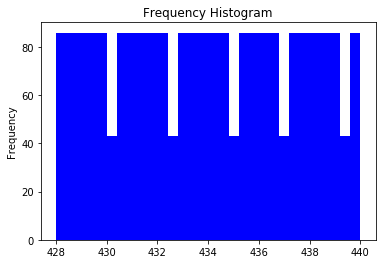

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.04%
Sado doorbell = 0.87%
LoRa 250 = 0.04%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


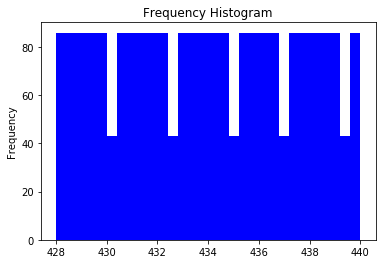

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


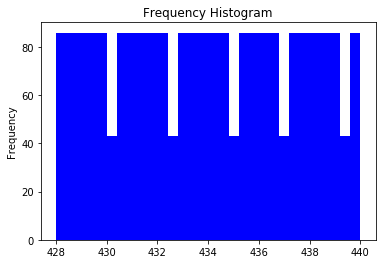

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


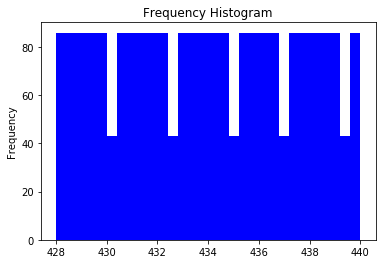

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


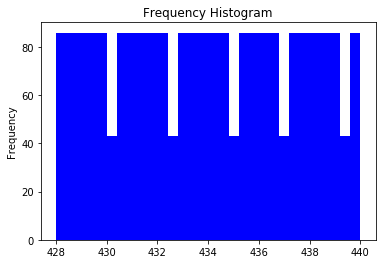

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


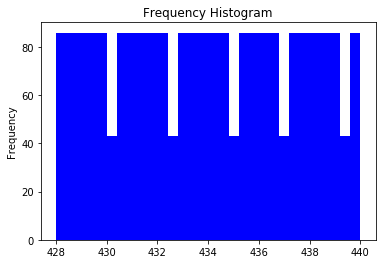

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.88%
LoRa 250 = 0.04%
light switch = 0.06%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


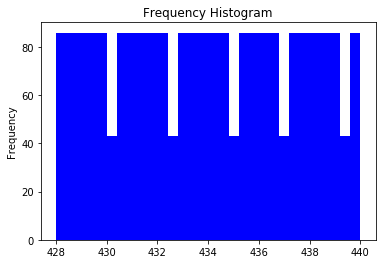

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


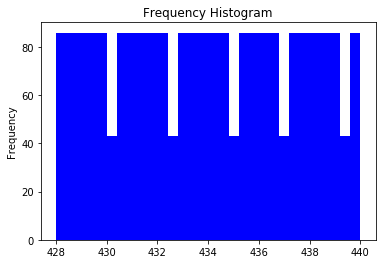

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.88%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


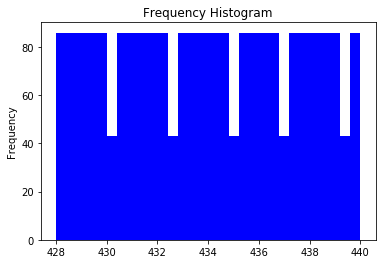

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.03%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


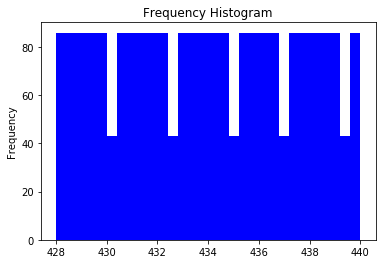

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.05%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [111]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_sado)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_sado)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("sado_25msps.csv", histogram, delimiter=",")
c = 6
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  UHF_TYT_DMR_test1.sigmf-meta
inference file name =  UHF_TYT_DMR_test10.sigmf-meta
inference file name =  UHF_TYT_DMR_test2.sigmf-meta
inference file name =  UHF_TYT_DMR_test3.sigmf-meta
inference file name =  UHF_TYT_DMR_test4.sigmf-meta
inference file name =  UHF_TYT_DMR_test5.sigmf-meta
inference file name =  UHF_TYT_DMR_test6.sigmf-meta
inference file name =  UHF_TYT_DMR_test7.sigmf-meta
inference file name =  UHF_TYT_DMR_test8.sigmf-meta
inference file name =  UHF_TYT_DMR_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


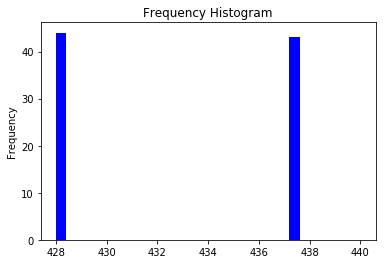

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     16.24
std Freq =     82.25
length of inputs =  2451


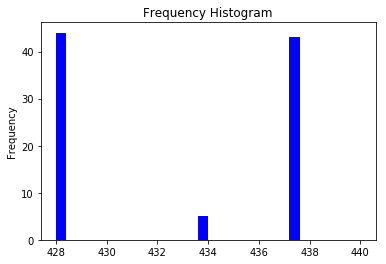

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.47%
TYT = 0.05
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.47%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2359
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     19.25
std Freq =     89.24
length of inputs =  2451


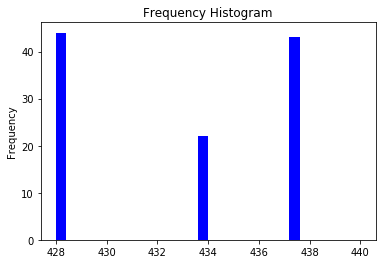

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.39%
TYT = 0.20
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.39%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2342
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


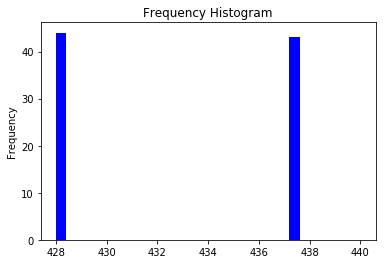

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


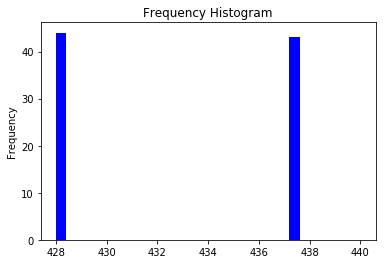

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


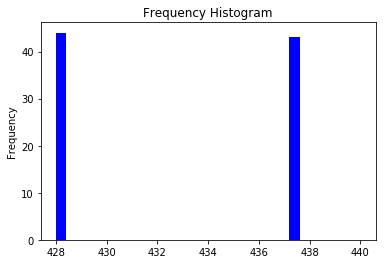

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.53
std Freq =     80.50
length of inputs =  2451


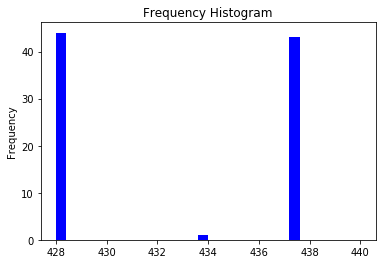

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.01
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2363
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.36
std Freq =     80.06
length of inputs =  2451


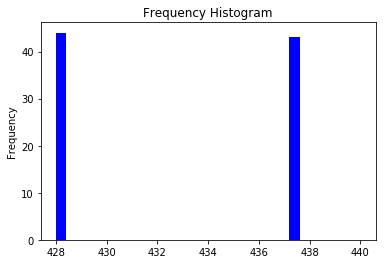

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.49%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.49%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2364
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.71
std Freq =     80.95
length of inputs =  2451


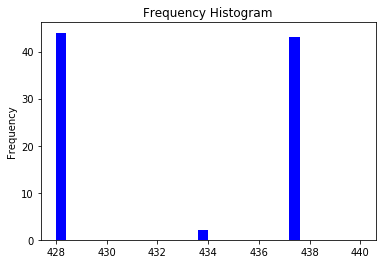

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.48%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.48%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2362
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =     15.71
std Freq =     80.95
length of inputs =  2451


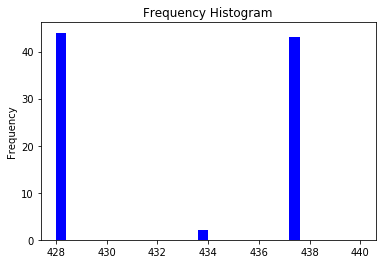

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.48%
TYT = 0.02
Vodeson Doorbell = 0.00%
clickndig = 0.01%
Sado doorbell = 0.48%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2362
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0 10  0  0  0  0  0  0  0]


In [112]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_tyt)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_tyt)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("tyt_25msps.csv", histogram, delimiter=",")
c = 3
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  UHF_vodeson_test1.sigmf-meta
inference file name =  UHF_vodeson_test10.sigmf-meta
inference file name =  UHF_vodeson_test2.sigmf-meta
inference file name =  UHF_vodeson_test3.sigmf-meta
inference file name =  UHF_vodeson_test4.sigmf-meta
inference file name =  UHF_vodeson_test5.sigmf-meta
inference file name =  UHF_vodeson_test6.sigmf-meta
inference file name =  UHF_vodeson_test7.sigmf-meta
inference file name =  UHF_vodeson_test8.sigmf-meta
inference file name =  UHF_vodeson_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


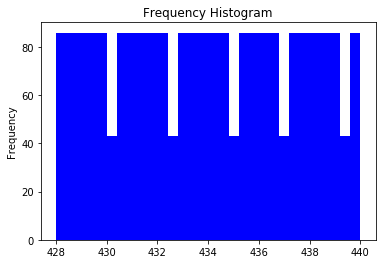

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.04%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


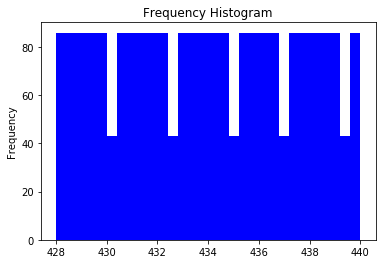

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


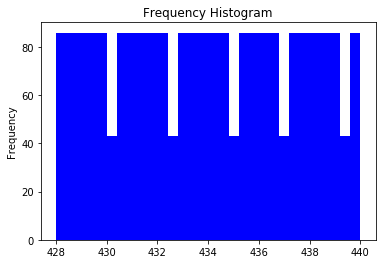

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


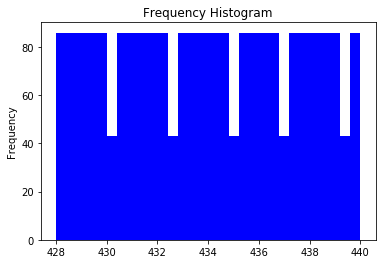

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


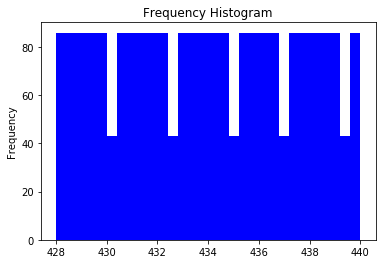

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.91%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


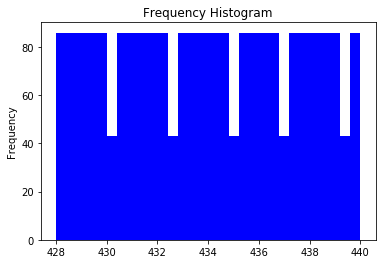

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


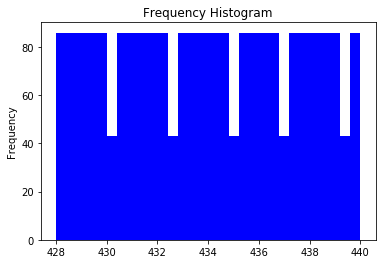

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


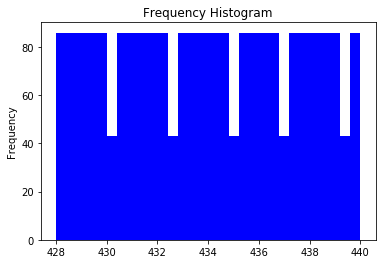

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.89%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


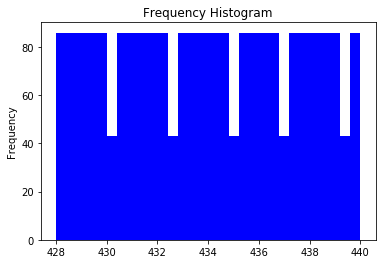

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =    434.14
std Freq =      3.61
length of inputs =  2451


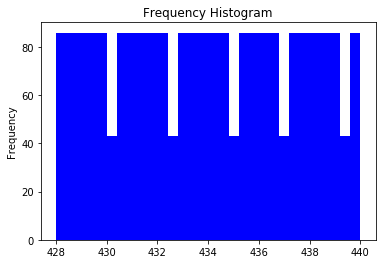

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.01%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.02%
Sado doorbell = 0.90%
LoRa 250 = 0.04%
light switch = 0.03%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  0
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [ 0  0  0  0  0  0 10  0  0  0]


In [113]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_vod)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_vod)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("vod_25msps.csv", histogram, delimiter=",")
c = 4
final_data_25msps[c,:] = pick(c,histogram)

inference file name =  ysf_25msps_test1.sigmf-meta
inference file name =  ysf_25msps_test10.sigmf-meta
inference file name =  ysf_25msps_test2.sigmf-meta
inference file name =  ysf_25msps_test3.sigmf-meta
inference file name =  ysf_25msps_test4.sigmf-meta
inference file name =  ysf_25msps_test5.sigmf-meta
inference file name =  ysf_25msps_test6.sigmf-meta
inference file name =  ysf_25msps_test7.sigmf-meta
inference file name =  ysf_25msps_test8.sigmf-meta
inference file name =  ysf_25msps_test9.sigmf-meta
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      6.40
std Freq =     52.41
length of inputs =  2451


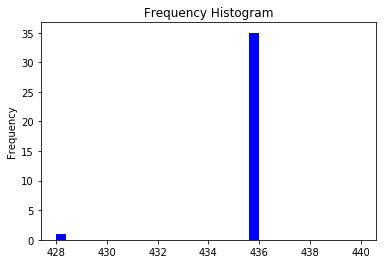

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.72%
clickndig = 0.03%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.25%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  8
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.82
std Freq =     57.85
length of inputs =  2451


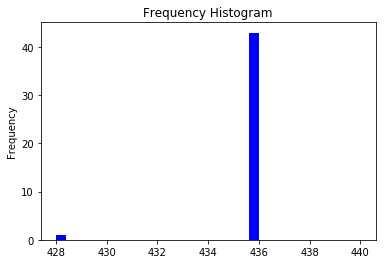

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.02%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.95%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      6.40
std Freq =     52.41
length of inputs =  2451


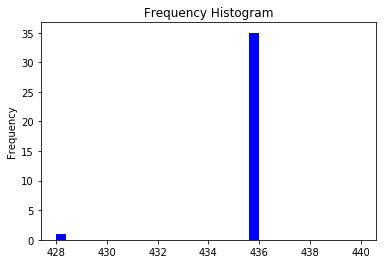

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.92%
clickndig = 0.03%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.06%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  8
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      6.22
std Freq =     51.69
length of inputs =  2451


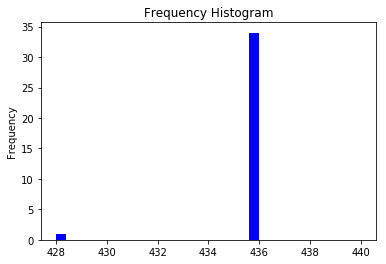

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.83%
clickndig = 0.03%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.14%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  9
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.47
std Freq =     56.55
length of inputs =  2451


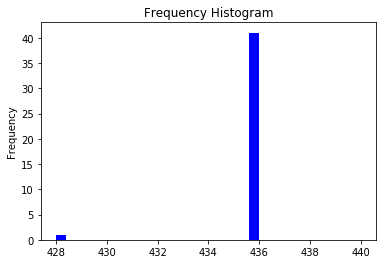

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.45%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.52%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  2
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      6.75
std Freq =     53.83
length of inputs =  2451


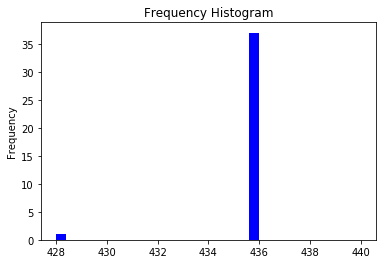

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.47%
clickndig = 0.03%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.50%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  6
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.82
std Freq =     57.85
length of inputs =  2451


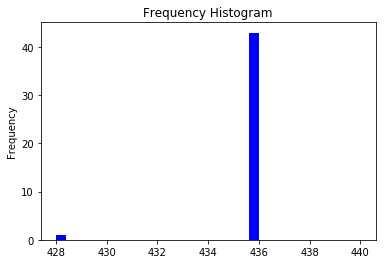

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.23%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.75%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.82
std Freq =     57.85
length of inputs =  2451


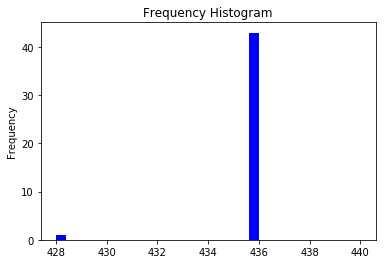

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.05%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.93%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.47
std Freq =     56.55
length of inputs =  2451


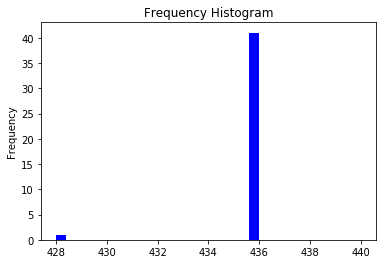

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.24%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.74%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  2
TOTAL patch count =  2451
***************************** Finished *********************************
iq_read_test file2
iq length =  torch.Size([12781, 9766, 4])
start_frequency =  428.0
mean Freq =      7.47
std Freq =     56.55
length of inputs =  2451


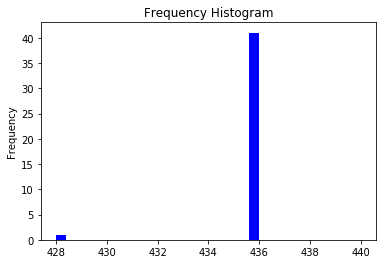

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.10%
clickndig = 0.02%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.88%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2407
center fft matches =  2
TOTAL patch count =  2451
***************************** Finished *********************************
class =  0  1  2  3  4  5  6  7  8  9
sum =  [0 0 0 0 3 0 0 0 0 7]


In [114]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6 @1MSPS
if choice==1:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps_ysf)
elif choice==2:
    data_IQ_list_val, meta_list_val = inference_read_file(msps, path2_test_25msps_ysf)
histogram_global, histogram = score_IQ_data_files(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()
os.chdir(path_output4D)
np.savetxt("ysf_25msps.csv", histogram, delimiter=",")
c = 9
final_data_25msps[c,:] = pick(c,histogram)

In [115]:
final_data_25msps = final_data_25msps.astype(int)
final_data_25msps

array([[ 5,  0,  1,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  0,  7,  0,  0,  0],
       [ 0,  4, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  7]])

In [116]:
np.trace(final_data_25msps)

37

In [117]:
os.chdir(path_confuse)
np.savetxt("ResNet50_20220210_1msps_train_score_25mspsdata_1classes.csv", final_data_25msps, delimiter=",")

In [ ]:
torch.cuda.empty_cache()